In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import sys
import glob
sys.path.append('../../../src')

from common import common, transform, json
from common.functions import cos_similarity
from common.json import IA_FORMAT, START_IDX, GA_FORMAT
from individual_activity.individual_activity import IndividualActivity
from display.display import display
from common.video import Video

In [2]:
def make_individuals(json_data, homo):
    individuals = {}
    for data in json_data:
        label = data[IA_FORMAT[0]]
        frame_num = data[IA_FORMAT[1]]
        tracking_point = data[IA_FORMAT[2]]
        keypoints = data[IA_FORMAT[3]]

        if label not in individuals:
            ia = IndividualActivity(label, homo)
            individuals[label] = ia
        else:
            ia = individuals[label]

        ia.tracking_points[frame_num] = tracking_point
        ia.keypoints[frame_num] = keypoints
        for f in IA_FORMAT[START_IDX:]:
            ia.indicator_dict[f][frame_num] = data[f]
            
    return individuals

# 分布

## 受け渡し動作中の距離の分布を見る

In [3]:
def calc_distanse(frame_num, label1, label2, individuals):
    id1 = individuals[label1]
    p1 = id1.indicator_dict[IA_FORMAT[START_IDX]][frame_num]
    
    id2 = individuals[label2]
    p2 = id2.indicator_dict[IA_FORMAT[START_IDX]][frame_num]
    
    if p1 is None or p2 is None:
        return None
    
    return np.linalg.norm(np.array(p1) - np.array(p2))


def extract_distanse(ia_lst, dirs, is_pass):
    hist = []
    for individuals, path in list(zip(ia_lst, dirs)):
        csv_path = f'{path}/csv/data.csv'
        csv_data = np.loadtxt(csv_path, delimiter=',', dtype=int, skiprows=1)
        # print(csv_path)
        for row in csv_data:
            frame_num = row[0]
            p1 = row[1]
            p2 = row[2]

            if row[3] == is_pass:
                dist = calc_distanse(frame_num, p1, p2, individuals)
                if dist is not None:
                    hist.append(dist)

    return hist


def extract_distanse_all(room_nums, dates, is_pass):
    hist = {}
    for room_num, date in tqdm(zip(room_nums, dates)):
        dirs = glob.glob(f'{common.data_dir}/{room_num}/{date}/passing/*')
        dirs = sorted(dirs)[:-1]  # delete make_csv.

        # homography
        field_path = os.path.join(common.data_dir, '{}/field.png'.format(room_num))
        field_raw = cv2.imread(field_path)
        p_video = common.homo[room_num][0]
        p_field = common.homo[room_num][1]
        homo = transform.Homography(p_video, p_field, field_raw.shape)

        ia_lst = []
        for path in dirs:
            path = f'{path}/json/individual_activity.json'
            json_data = json.load(path)
            individuals = make_individuals(json_data, homo)
            ia_lst.append(individuals)
            
        hist[room_num] = extract_distanse(ia_lst, dirs, is_pass)
    
    return hist

In [4]:
hist_dist_1 = extract_distanse_all(
    ['02', '08', '09'],
    ['20210903', '20210915', '20210706'],
    1
)

3it [00:11,  3.82s/it]


180.75893689120585
82.47332045908828


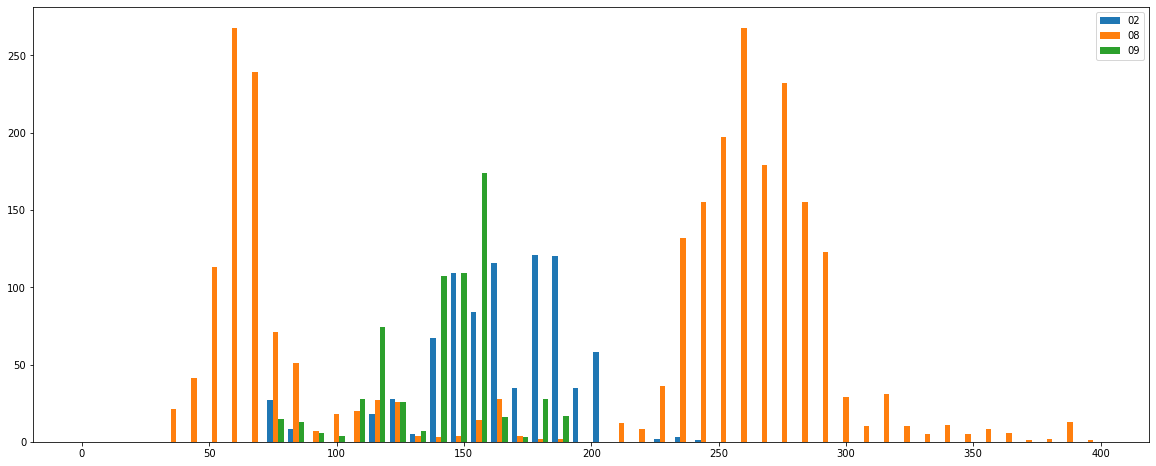

In [5]:
data = []
for vals in hist_dist_1.values():
    data += vals
print(np.mean(data))
print(np.std(data))

plt.figure(figsize=(20, 8))
plt.hist(hist_dist_1.values(), bins=50, range=(0, 400), label=list(hist_dist_1.keys()))
plt.legend()

In [6]:
hist_dist_0 = extract_distanse_all(
    ['02', '08', '09'],
    ['20210903', '20210915', '20210706'],
    0
)

3it [00:14,  4.87s/it]


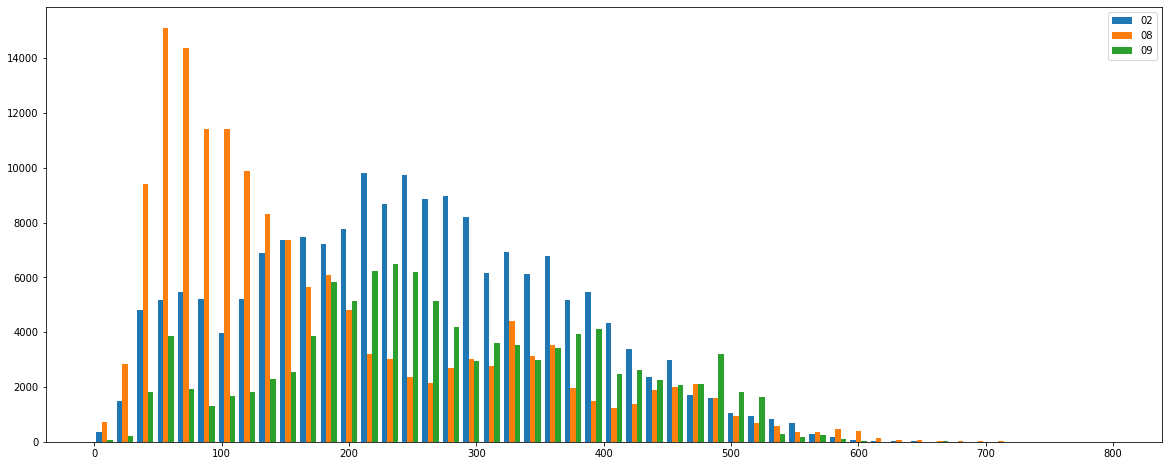

In [7]:
plt.figure(figsize=(20, 8))
plt.hist(hist_dist_0.values(), bins=50, range=(0, 800), label=list(hist_dist_0.keys()))
plt.legend()

## 受け渡し動作中の体の向きの分布を見る

In [8]:
def calc_body_direction(frame_num, label1, label2, individuals):
    id1 = individuals[label1]
    p1 = id1.indicator_dict[IA_FORMAT[START_IDX]][frame_num]
    body1 = id1.indicator_dict[IA_FORMAT[START_IDX + 2]][frame_num]
    
    id2 = individuals[label2]
    p2 = id2.indicator_dict[IA_FORMAT[START_IDX]][frame_num]
    body2 = id2.indicator_dict[IA_FORMAT[START_IDX + 2]][frame_num]
    
    if p1 is None or body1 is None or p2 is None or body2 is None:
        return None
    
    p1 = np.array(p1)
    p2 = np.array(p2)
    p1p2 = p2 - p1
    p2p1 = p1 - p2
    p1_sim = cos_similarity(body1, p1p2)
    p2_sim = cos_similarity(body2, p2p1)
    body_direction = np.average([p1_sim, p2_sim])
    
    return body_direction


def extract_body_direction(ia_lst, dirs, is_pass):
    hist = []
    for individuals, path in list(zip(ia_lst, dirs)):
        csv_path = f'{path}/csv/data.csv'
        csv_data = np.loadtxt(csv_path, delimiter=',', dtype=int, skiprows=1)
        # print(csv_path)
        for row in csv_data:
            frame_num = row[0]
            p1 = row[1]
            p2 = row[2]

            if row[3] == is_pass:
                d = calc_body_direction(frame_num, p1, p2, individuals)
                if d is not None:
                    hist.append(d)

    return hist


def extract_body_direction_all(room_nums, dates, is_pass):
    hist = {}
    for room_num, date in tqdm(zip(room_nums, dates)):
        dirs = glob.glob(f'{common.data_dir}/{room_num}/{date}/passing/*')
        dirs = sorted(dirs)[:-1]  # delete make_csv.

        # homography
        field_path = os.path.join(common.data_dir, '{}/field.png'.format(room_num))
        field_raw = cv2.imread(field_path)
        p_video = common.homo[room_num][0]
        p_field = common.homo[room_num][1]
        homo = transform.Homography(p_video, p_field, field_raw.shape)

        ia_lst = []
        for path in dirs:
            path = f'{path}/json/individual_activity.json'
            json_data = json.load(path)
            individuals = make_individuals(json_data, homo)
            ia_lst.append(individuals)
            
        hist[room_num] = extract_body_direction(ia_lst, dirs, is_pass)
    
    return hist

In [9]:
hist_body_direction_1 = extract_body_direction_all(
    ['02', '08', '09'],
    ['20210903', '20210915', '20210706'],
    1
)

3it [00:11,  3.84s/it]


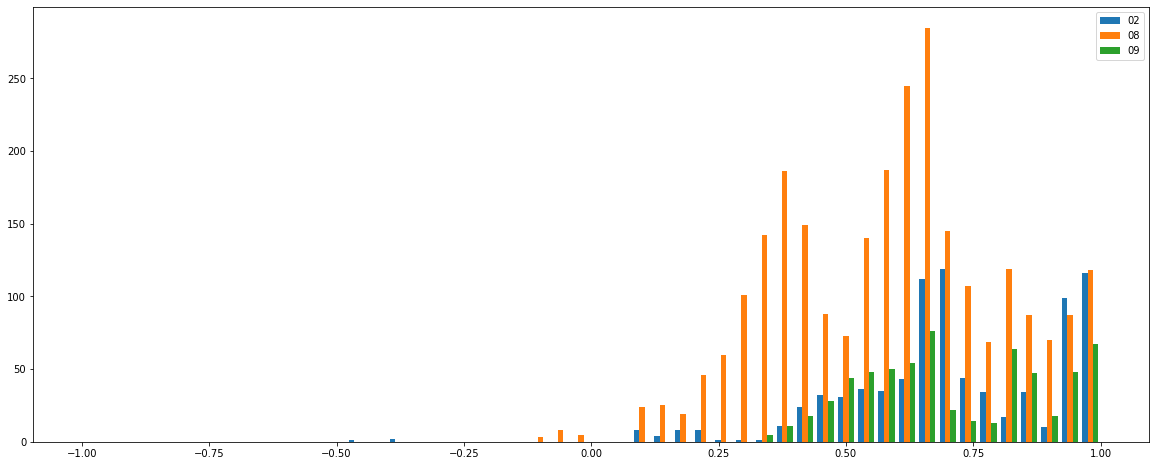

In [10]:
plt.figure(figsize=(20, 8))
plt.hist(hist_body_direction_1.values(), bins=50, range=(-1, 1), label=list(hist_body_direction_1.keys()))
plt.legend()

In [11]:
hist_body_direction_0 = extract_body_direction_all(
    ['02', '08', '09'],
    ['20210903', '20210915', '20210706'],
    0
)

3it [00:25,  8.66s/it]


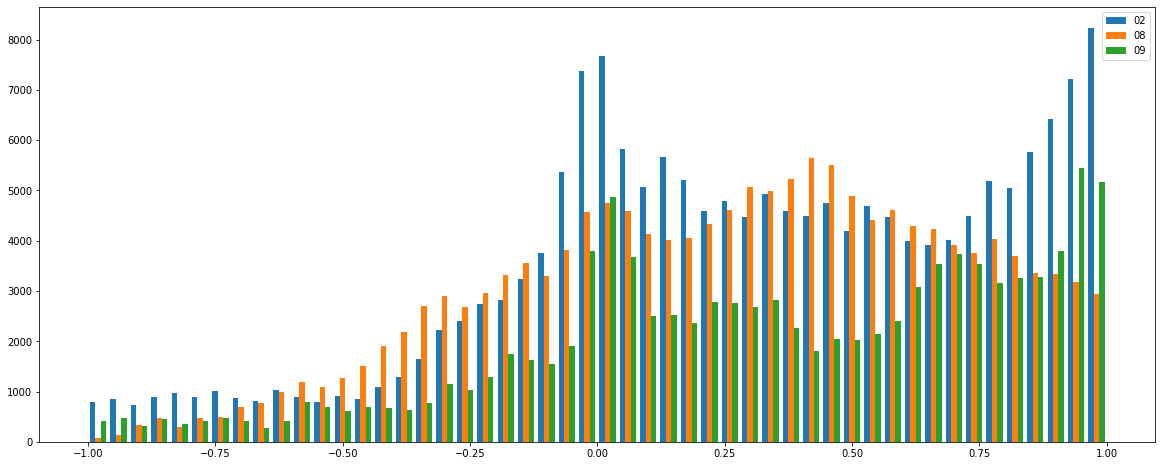

In [12]:
plt.figure(figsize=(20, 8))
plt.hist(hist_body_direction_0.values(), bins=50, range=(-1, 1), label=list(hist_body_direction_0.keys()))
plt.legend()

## 受け渡し動作中の腕の上げ下げの分布を見る

In [13]:
def calc_arm(frame_num, label1, label2, individuals):
    id1 = individuals[label1]
    p1 = id1.indicator_dict[IA_FORMAT[START_IDX]][frame_num]
    a1 = id1.indicator_dict[IA_FORMAT[START_IDX + 3]][frame_num]
    
    id2 = individuals[label2]
    p2 = id2.indicator_dict[IA_FORMAT[START_IDX]][frame_num]
    a2 = id2.indicator_dict[IA_FORMAT[START_IDX + 3]][frame_num]
    
    if p1 is None or a1 is None or p2 is None or a2 is None:
        return None
    
    arm_ave = np.average([a1, a2])
    
    return arm_ave


def extract_arm(ia_lst, dirs, is_pass):
    hist = []
    for individuals, path in list(zip(ia_lst, dirs)):
        csv_path = f'{path}/csv/data.csv'
        csv_data = np.loadtxt(csv_path, delimiter=',', dtype=int, skiprows=1)
        # print(csv_path)
        for row in csv_data:
            frame_num = row[0]
            p1 = row[1]
            p2 = row[2]

            if row[3] == is_pass:
                a = calc_arm(frame_num, p1, p2, individuals)
                if a is not None:
                    hist.append(a)

    return hist


def extract_arm_all(room_nums, dates, is_pass):
    hist = {}
    for room_num, date in tqdm(zip(room_nums, dates)):
        dirs = glob.glob(f'{common.data_dir}/{room_num}/{date}/passing/*')
        dirs = sorted(dirs)[:-1]  # delete make_csv.

        # homography
        field_path = os.path.join(common.data_dir, '{}/field.png'.format(room_num))
        field_raw = cv2.imread(field_path)
        p_video = common.homo[room_num][0]
        p_field = common.homo[room_num][1]
        homo = transform.Homography(p_video, p_field, field_raw.shape)

        ia_lst = []
        for path in dirs:
            path = f'{path}/json/individual_activity.json'
            json_data = json.load(path)
            individuals = make_individuals(json_data, homo)
            ia_lst.append(individuals)
            
        hist[room_num] = extract_arm(ia_lst, dirs, is_pass)
    
    return hist

In [14]:
hist_arm_1 = extract_arm_all(
    ['02', '08', '09'],
    ['20210903', '20210915', '20210706'],
    1
)

3it [00:11,  3.87s/it]


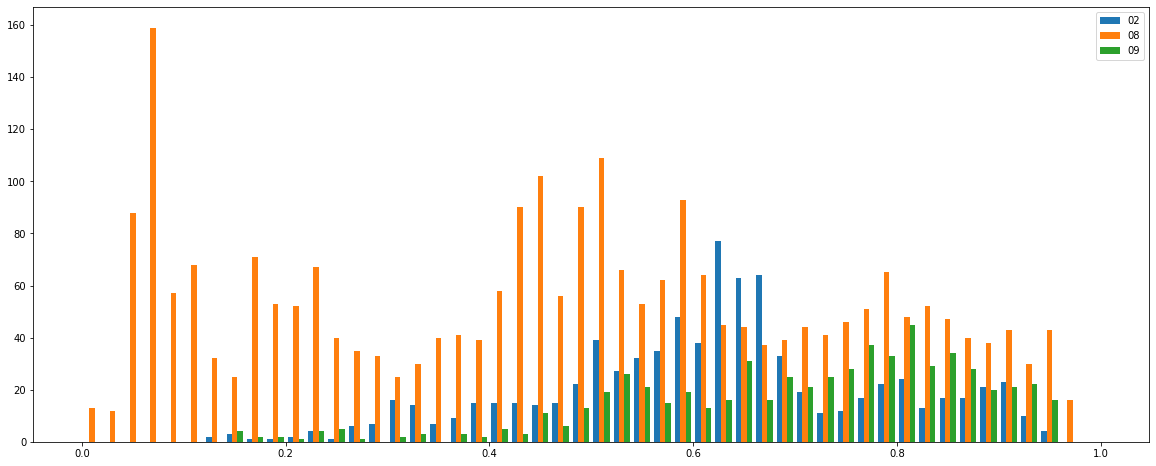

In [15]:
plt.figure(figsize=(20, 8))
plt.hist(hist_arm_1.values(), bins=50, range=(0, 1), label=list(hist_arm_1.keys()))
plt.legend()

In [16]:
hist_arm_0 = extract_arm_all(
    ['02', '08', '09'],
    ['20210903', '20210915', '20210706'],
    0
)

3it [00:14,  4.98s/it]


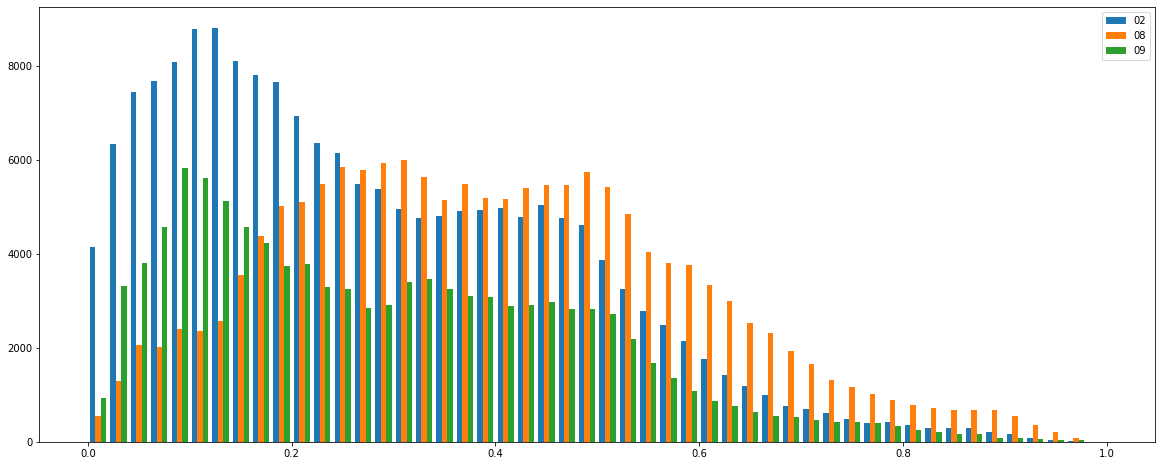

In [17]:
plt.figure(figsize=(20, 8))
plt.hist(hist_arm_0.values(), bins=50, range=(0, 1), label=list(hist_arm_0.keys()))
plt.legend()

## 受け渡し動作中の手首の距離の分布を見る

In [31]:
def calc_wrist(frame_num, label1, label2, individuals):
    id1 = individuals[label1]
    p1 = id1.indicator_dict[IA_FORMAT[START_IDX]][frame_num]
    w1 = [
        id1.get_keypoints('LWrist', frame_num),
        id1.get_keypoints('RWrist', frame_num)
    ]
    
    id2 = individuals[label2]
    p2 = id2.indicator_dict[IA_FORMAT[START_IDX]][frame_num]
    w2 = [
        id2.get_keypoints('LWrist', frame_num),
        id2.get_keypoints('RWrist', frame_num)
    ]
    
    if p1 is None or w1 is None or p2 is None or w2 is None:
        return None
    
    min_norm = np.inf
    for i in range(2):
        for j in range(2):
            norm = np.linalg.norm(
                np.array(w1[i]) - np.array(w2[j]), ord=2)
            if norm < min_norm:
                min_norm = norm
    if min_norm < np.inf:
        return min_norm
    else:
        return None


def extract_wrist(ia_lst, dirs, is_pass):
    hist = []
    for individuals, path in list(zip(ia_lst, dirs)):
        csv_path = f'{path}/csv/data.csv'
        csv_data = np.loadtxt(csv_path, delimiter=',', dtype=int, skiprows=1)
        # print(csv_path)
        for row in csv_data:
            frame_num = row[0]
            p1 = row[1]
            p2 = row[2]

            if row[3] == is_pass:
                a = calc_wrist(frame_num, p1, p2, individuals)
                if a is not None:
                    hist.append(a)

    return hist


def extract_wrist_all(room_nums, dates, is_pass):
    hist = {}
    for room_num, date in tqdm(zip(room_nums, dates)):
        dirs = glob.glob(f'{common.data_dir}/{room_num}/{date}/passing/*')
        dirs = sorted(dirs)[:-1]  # delete make_csv.

        # homography
        field_path = os.path.join(common.data_dir, '{}/field.png'.format(room_num))
        field_raw = cv2.imread(field_path)
        p_video = common.homo[room_num][0]
        p_field = common.homo[room_num][1]
        homo = transform.Homography(p_video, p_field, field_raw.shape)

        ia_lst = []
        for path in dirs:
            path = f'{path}/json/individual_activity.json'
            json_data = json.load(path)
            individuals = make_individuals(json_data, homo)
            ia_lst.append(individuals)
            
        hist[room_num] = extract_wrist(ia_lst, dirs, is_pass)
    
    return hist

In [33]:
hist_wrist_1 = extract_wrist_all(
    ['02', '08', '09'],
    ['20210903', '20210915', '20210706'],
    1
)

3it [00:11,  3.94s/it]


97.68773381575826
56.09741397506308


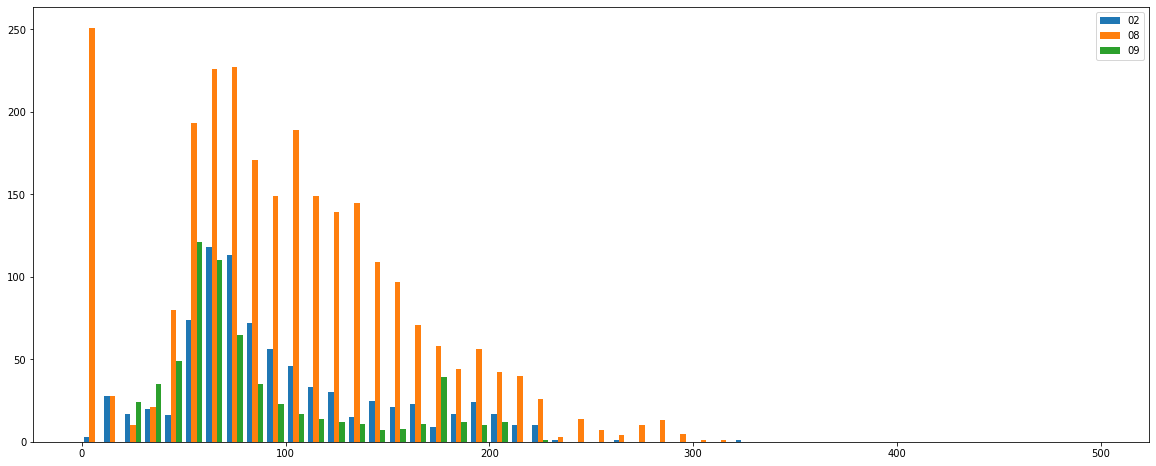

In [36]:
data = []
for vals in hist_wrist_1.values():
    data += vals
print(np.mean(data))
print(np.std(data))

plt.figure(figsize=(20, 8))
plt.hist(hist_wrist_1.values(), bins=50, range=(0, 500), label=list(hist_wrist_1.keys()))
plt.legend()

In [37]:
hist_wrist_0 = extract_wrist_all(
    ['02', '08', '09'],
    ['20210903', '20210915', '20210706'],
    0
)

3it [00:24,  8.24s/it]


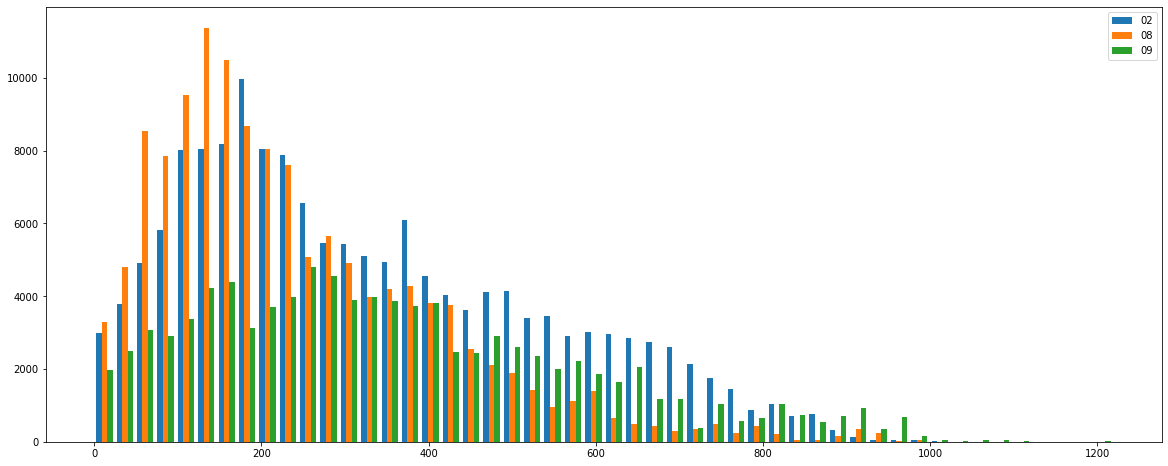

In [39]:
plt.figure(figsize=(20, 8))
plt.hist(hist_wrist_0.values(), bins=50, label=list(hist_wrist_0.keys()))
plt.legend()

# 時系列でプロット

In [184]:
def plot_time_series(data, is_pass, ylim=None):
    for key, values in data.items():
        if is_pass in values['is_pass']:
            num, label1, label2 = key.split('_')
            
            fig = plt.figure(figsize=(20, 6))
            ax = fig.add_subplot(2, 1, 1)
            ax.plot(values['values'])
            if ylim is not None:
                ax.set_ylim(ylim)
            ax1 = ax.twinx()
            ax1.plot(values['is_pass'], linestyle='--', color='orange')
            ax1.set_ylim((-0.05, 1.05))

            # diffs = [0] + np.diff(values['values']).tolist()
            # ax = fig.add_subplot(2, 1, 2)
            # ax.plot(diffs)
            # ax1 = ax.twinx()
            # ax1.plot(values['is_pass'], linestyle='--')
            # ax1.set_ylim((-0.05, 1.05))
            plt.title(f'file number: {num}, person {label1} vs person {label2}')
            plt.plot()

## 距離

In [164]:
def extract_time_series_distanse(ia_lst, dirs, max_len=30):
    data = {}
    for individuals, path in list(zip(ia_lst, dirs)):
        csv_path = f'{path}/csv/data.csv'
        csv_data = np.loadtxt(csv_path, delimiter=',', dtype=int, skiprows=1)

        for row in csv_data:
            frame_num = row[0]
            p1 = row[1]
            p2 = row[2]
            
            key = path[-2:] + '_' + str(p1) + '_'  + str(p2)
            if key not in data:
                data[key] = {'is_pass': [], 'values':[]}
            values = data[key]

            values['is_pass'].append(row[3])
            val = calc_distanse(frame_num, p1, p2, individuals)
            values['values'].append(val)
            
    del_lst = []
    for key, values in data.items():
        if len(values['values']) < max_len:
            del_lst.append(key)
            
    for key in del_lst:
        del data[key]

    return data


def extract_distanse_time_series_all(room_num, date, max_len=30):
    dirs = glob.glob(f'{common.data_dir}/{room_num}/{date}/passing/*')
    dirs = sorted(dirs)[:-1]  # delete make_csv.

    # homography
    field_path = os.path.join(common.data_dir, '{}/field.png'.format(room_num))
    field_raw = cv2.imread(field_path)
    p_video = common.homo[room_num][0]
    p_field = common.homo[room_num][1]
    homo = transform.Homography(p_video, p_field, field_raw.shape)

    ia_lst = []
    for path in dirs:
        path = f'{path}/json/individual_activity.json'
        json_data = json.load(path)
        individuals = make_individuals(json_data, homo)
        ia_lst.append(individuals)

    data = extract_time_series_distanse(ia_lst, dirs, max_len)
    
    return data

In [165]:
dist_02 = extract_distanse_time_series_all('02','20210903')

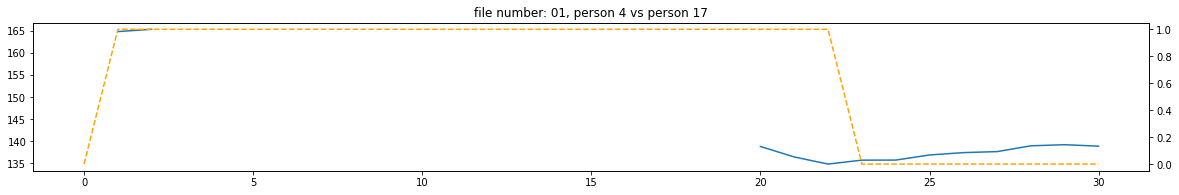

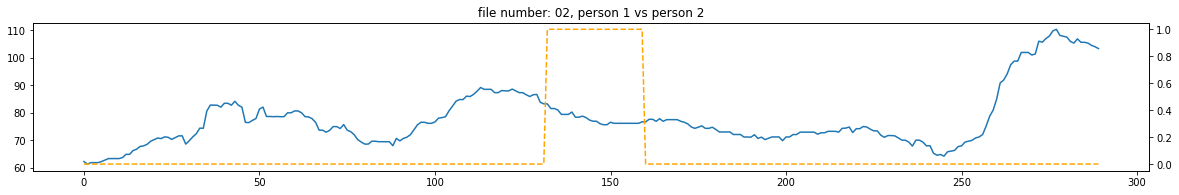

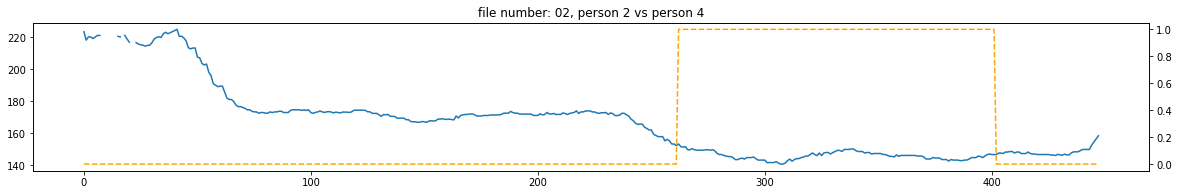

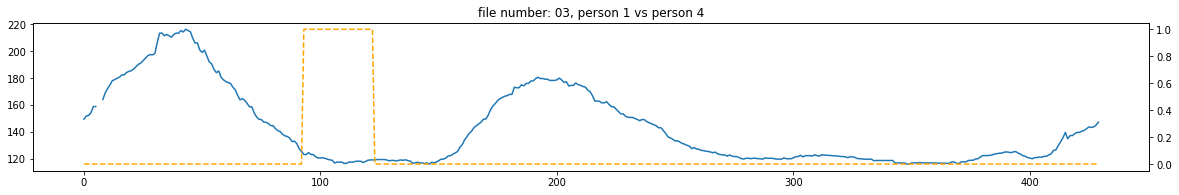

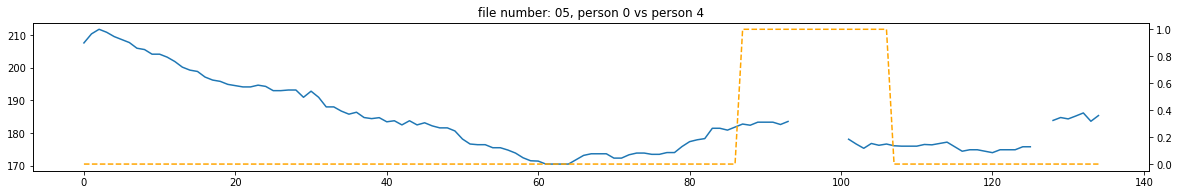

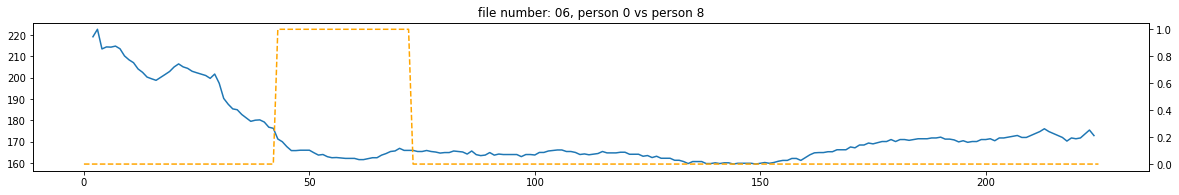

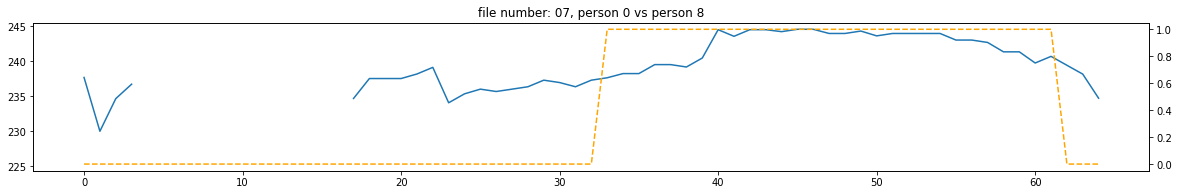

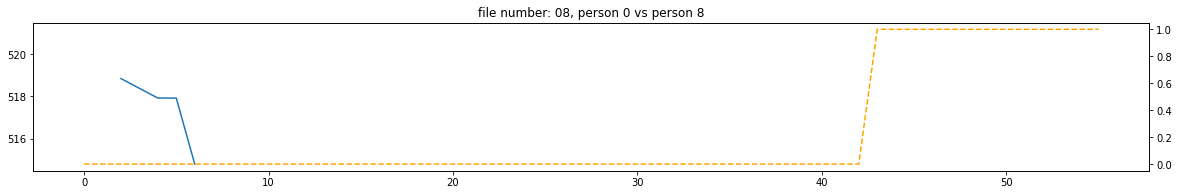

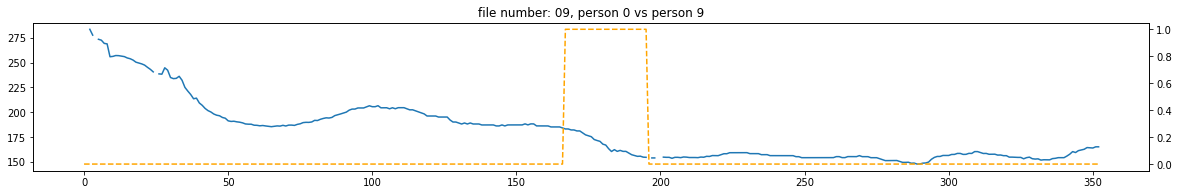

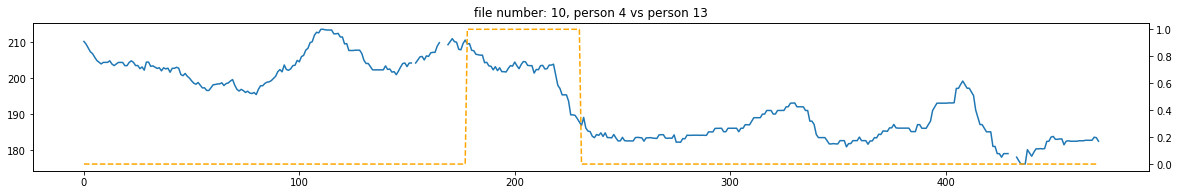

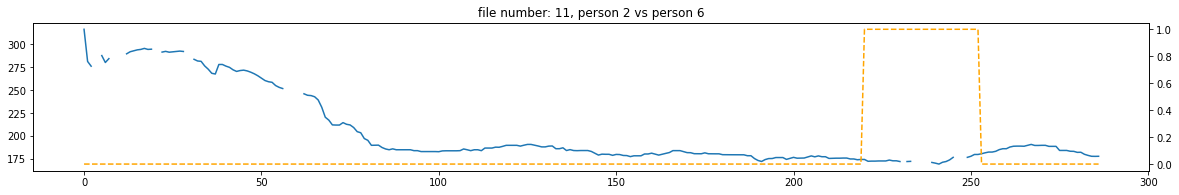

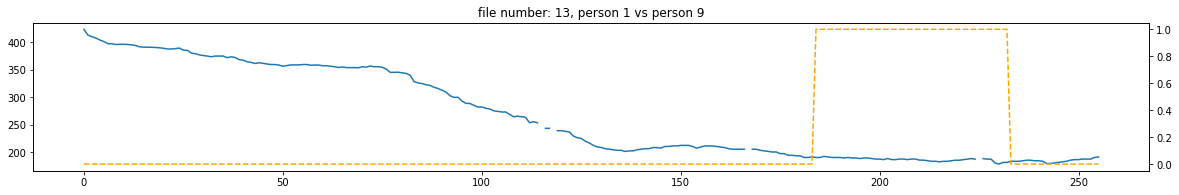

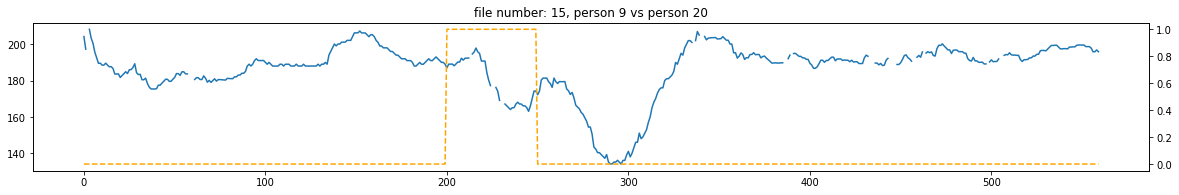

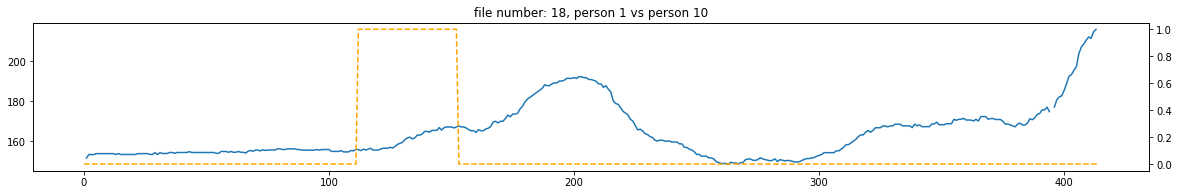

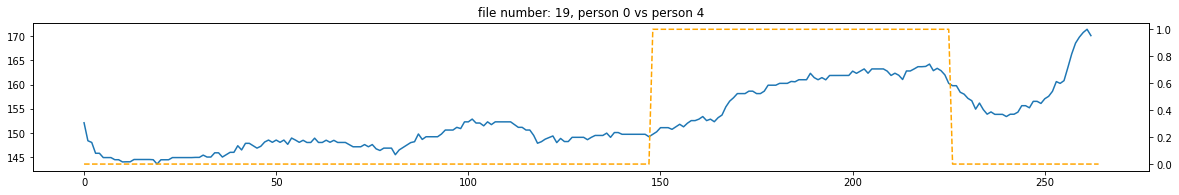

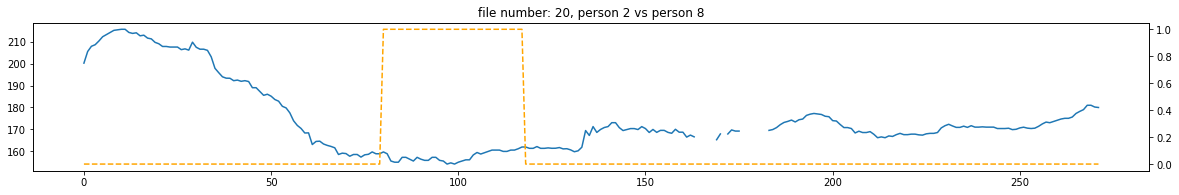

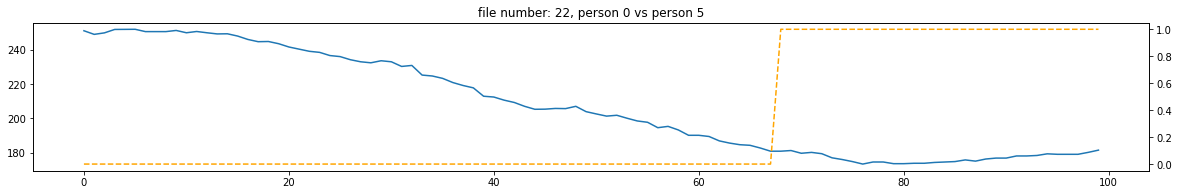

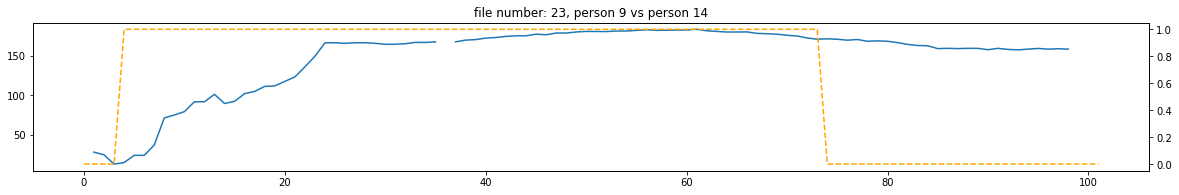

In [166]:
plot_time_series(dist_02, is_pass=1)

In [171]:
dist_08 = extract_distanse_time_series_all('08','20210915')

/tmp/ipykernel_3989/2595903379.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(20, 6))


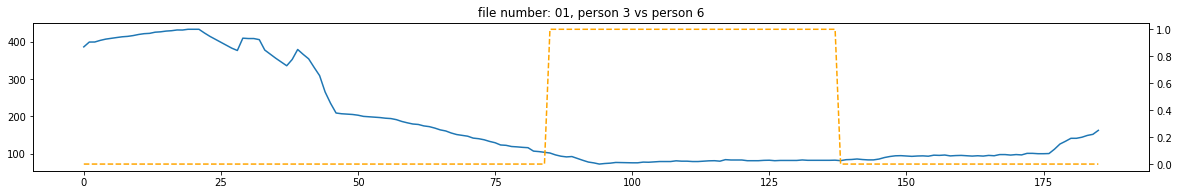

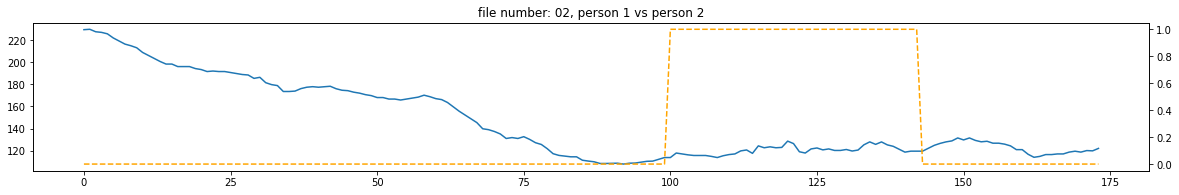

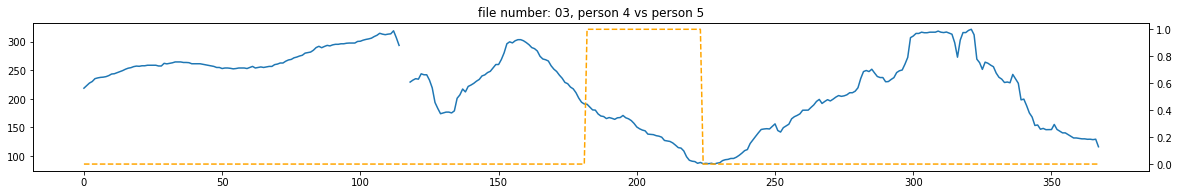

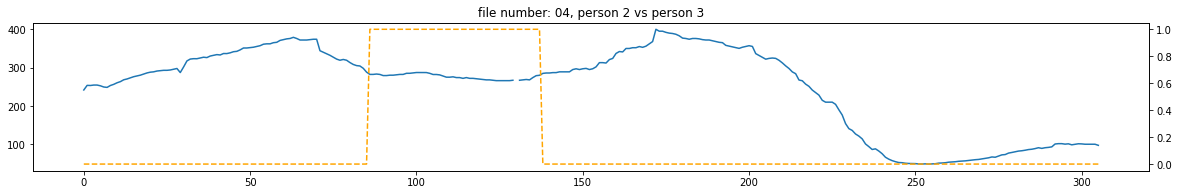

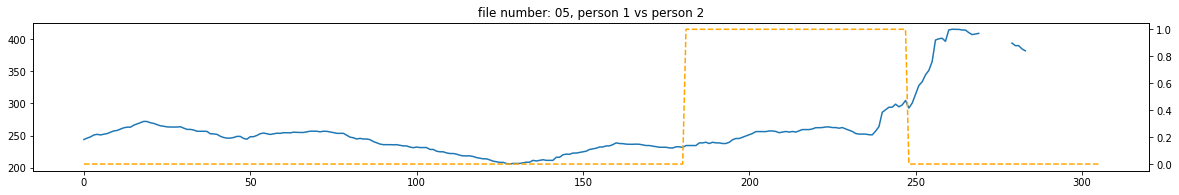

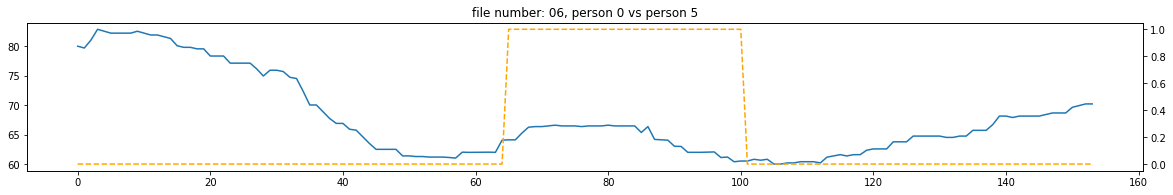

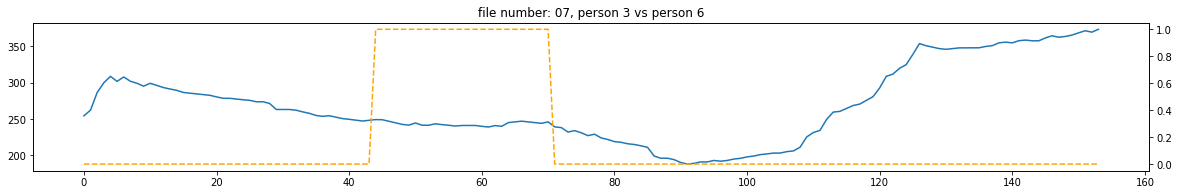

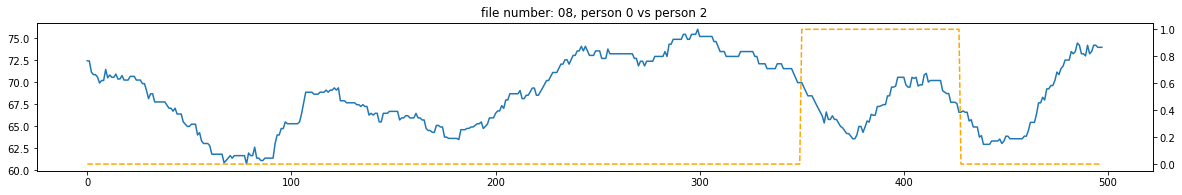

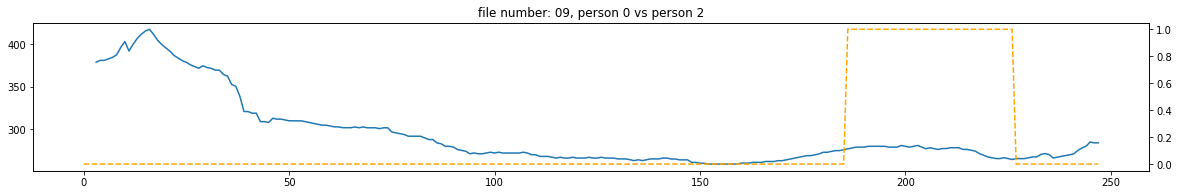

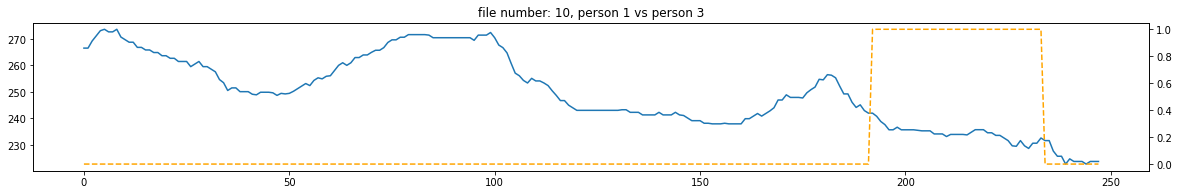

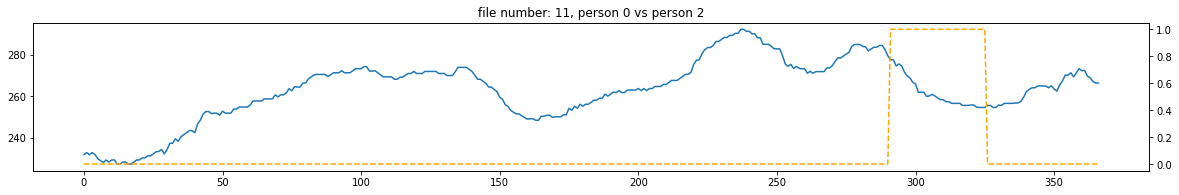

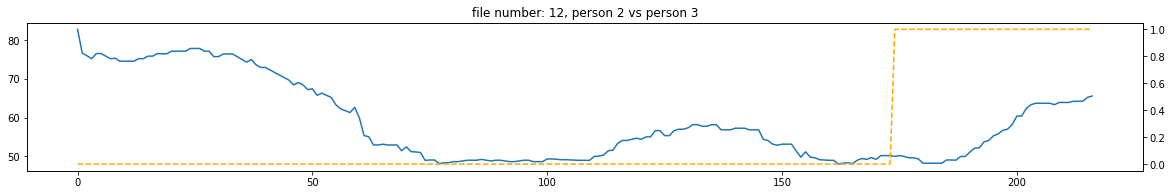

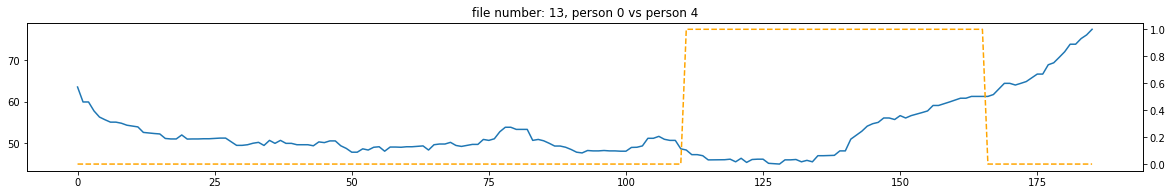

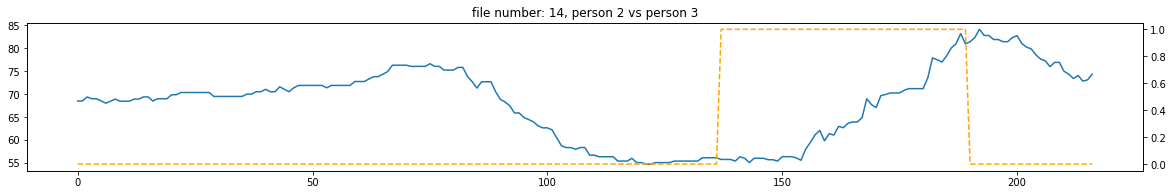

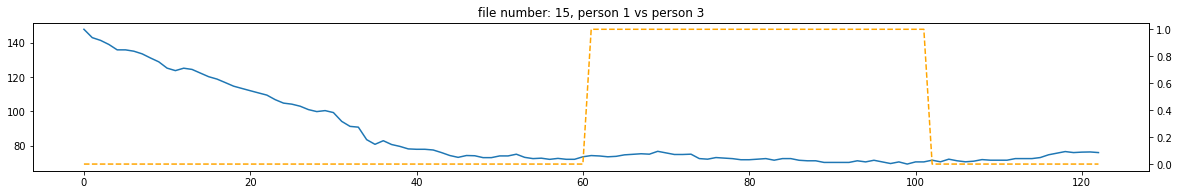

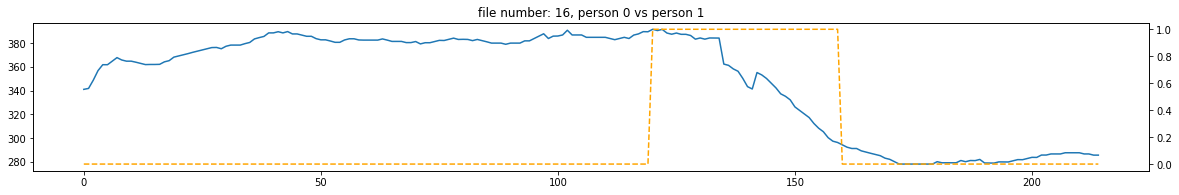

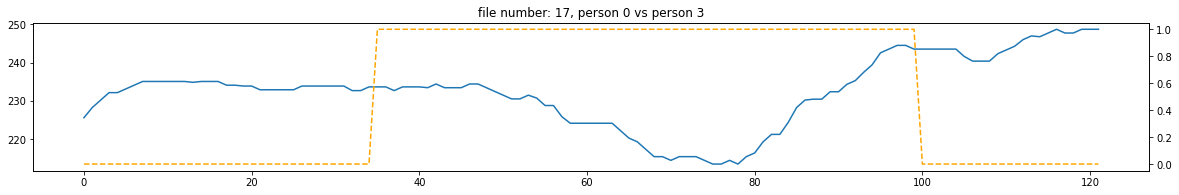

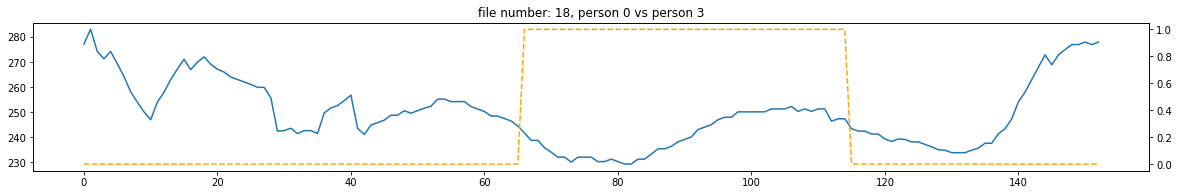

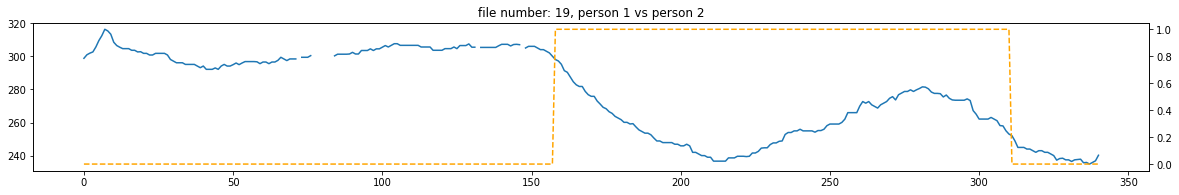

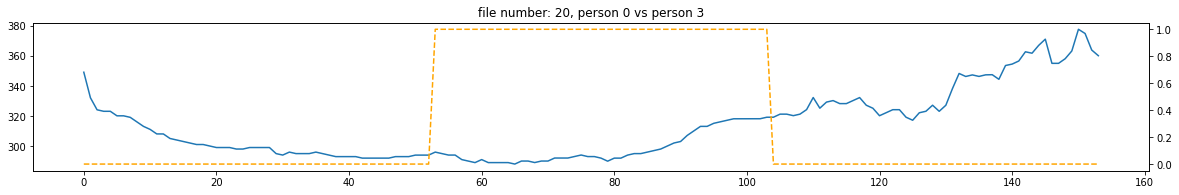

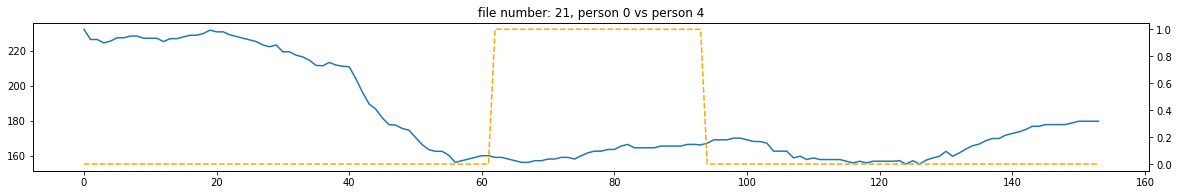

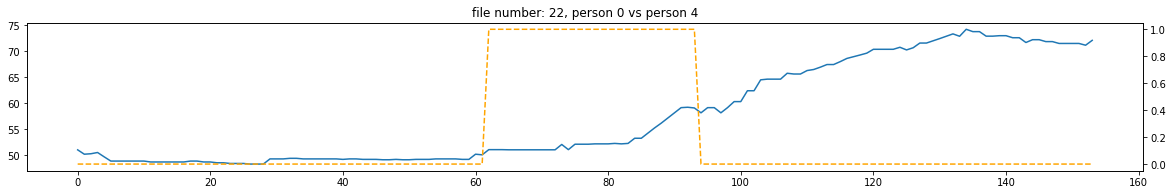

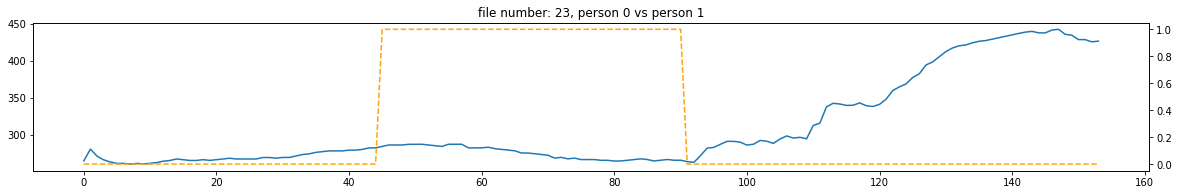

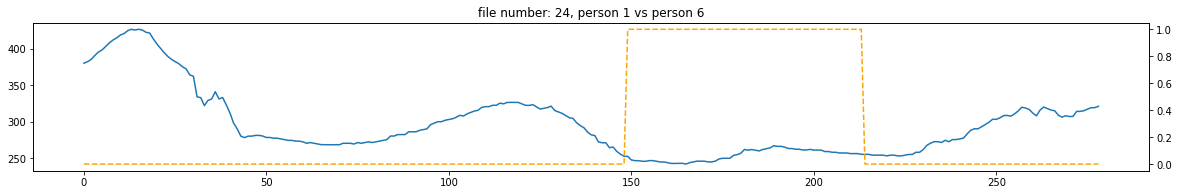

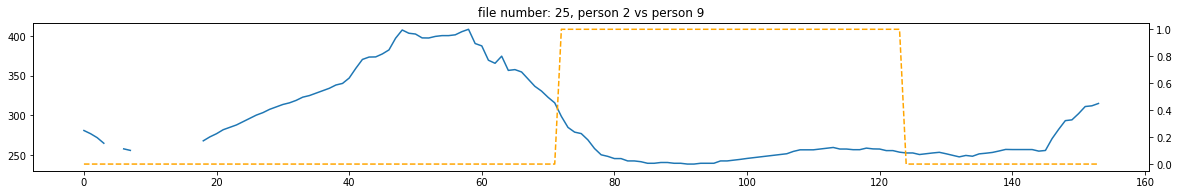

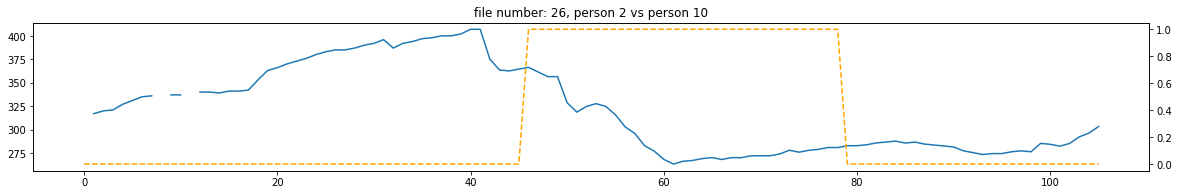

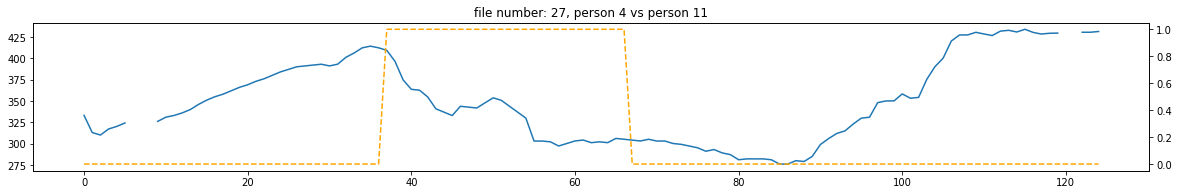

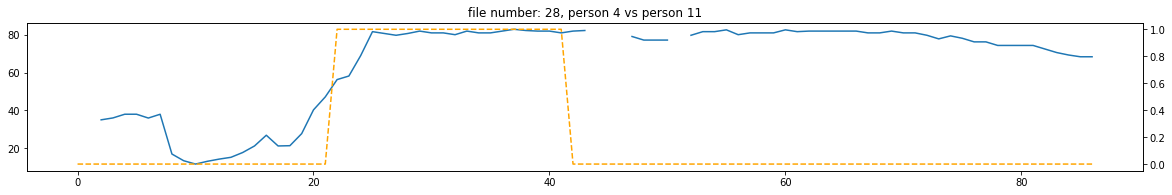

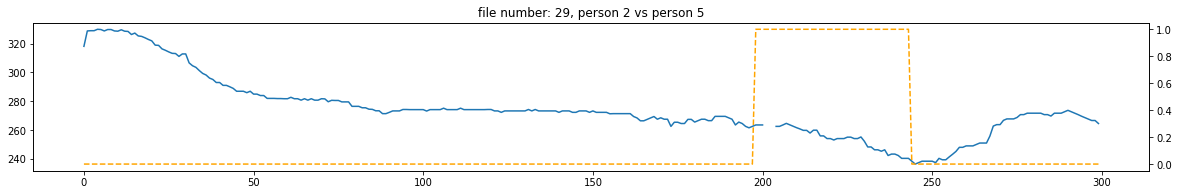

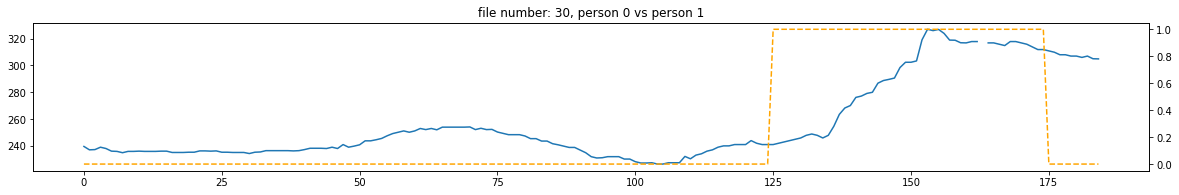

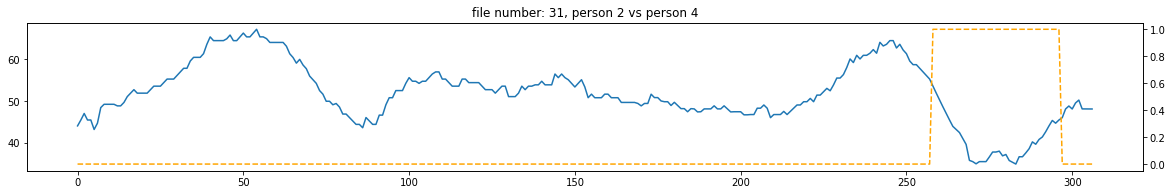

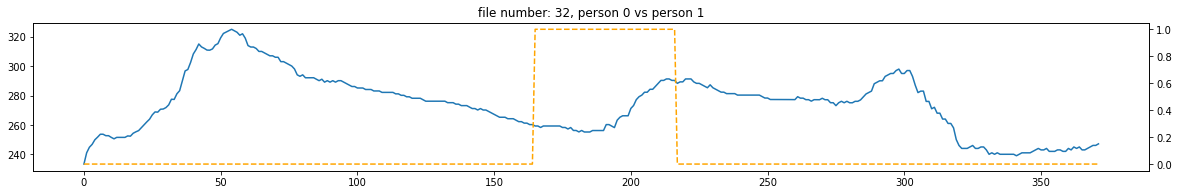

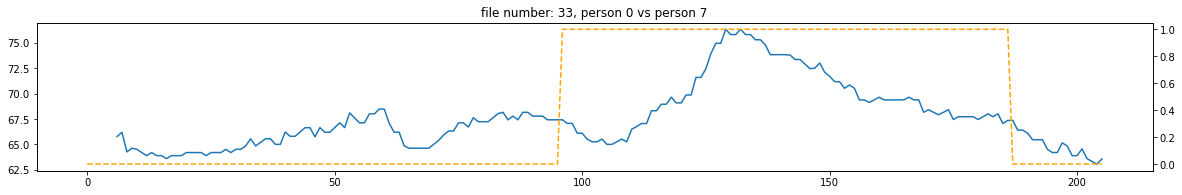

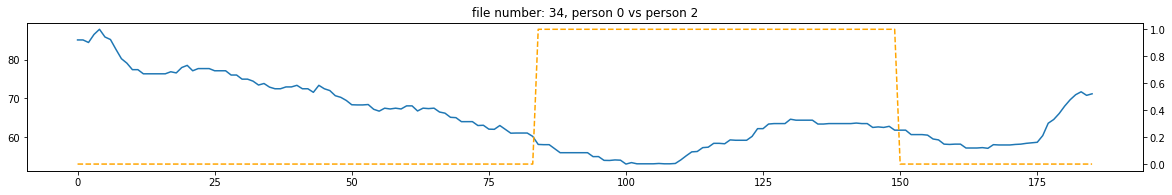

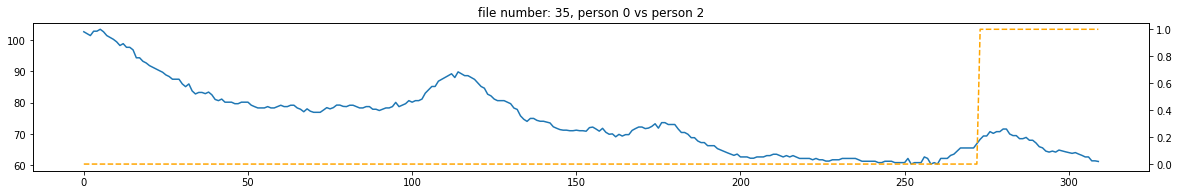

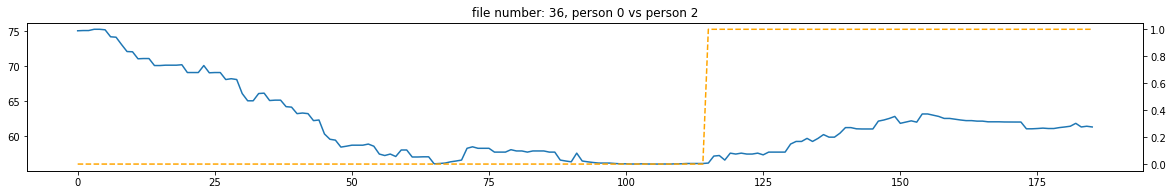

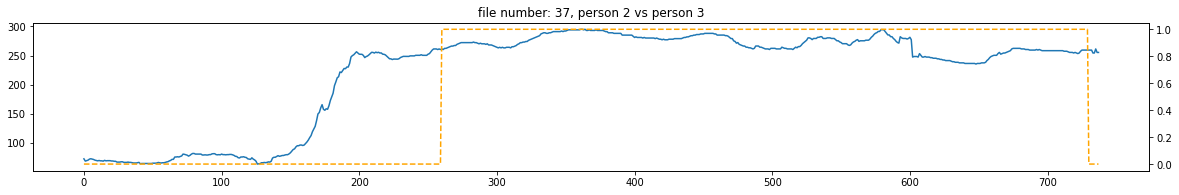

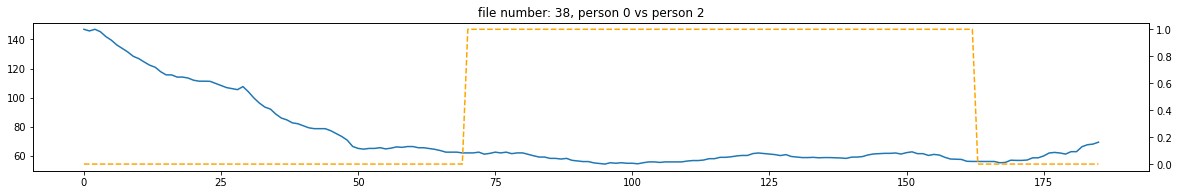

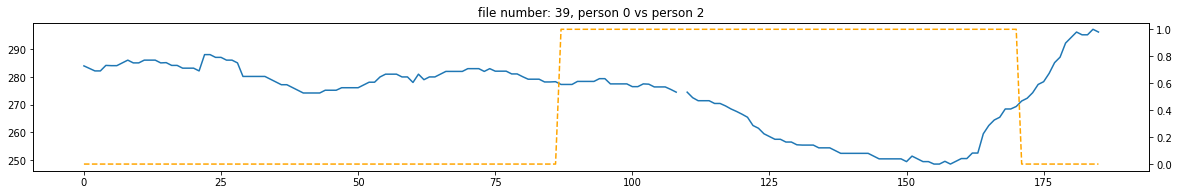

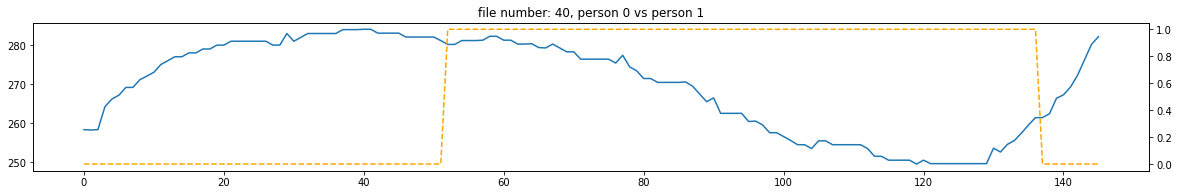

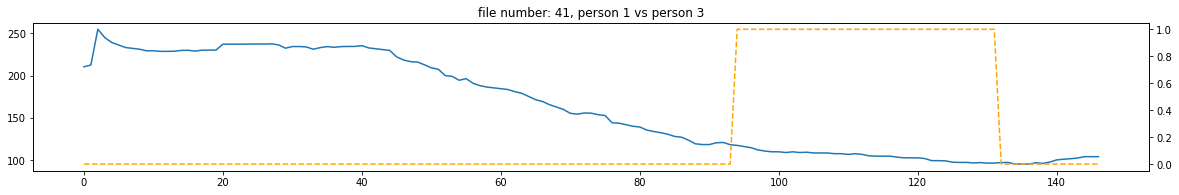

In [172]:
plot_time_series(dist_08, is_pass=1)

In [173]:
dist_09 = extract_distanse_time_series_all('09','20210706')

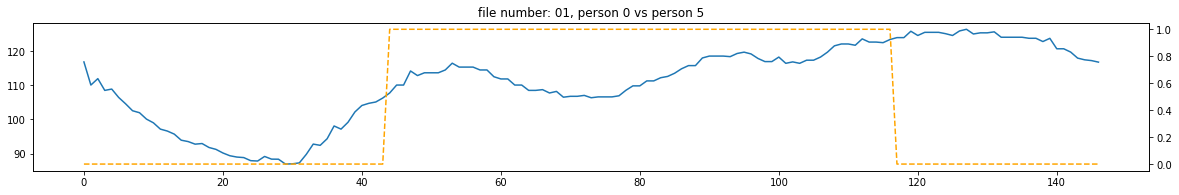

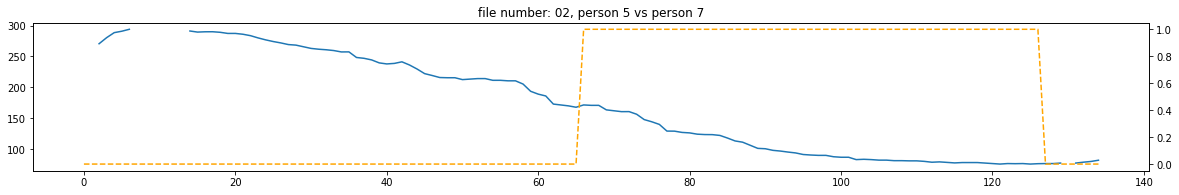

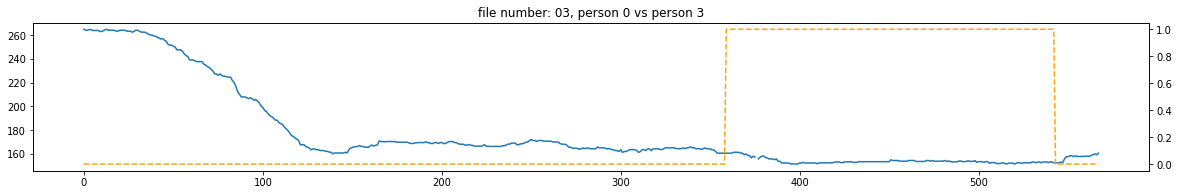

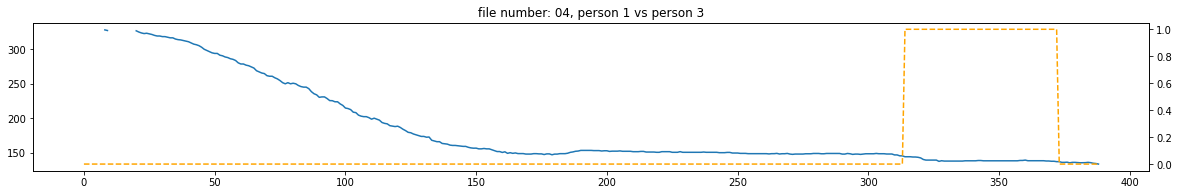

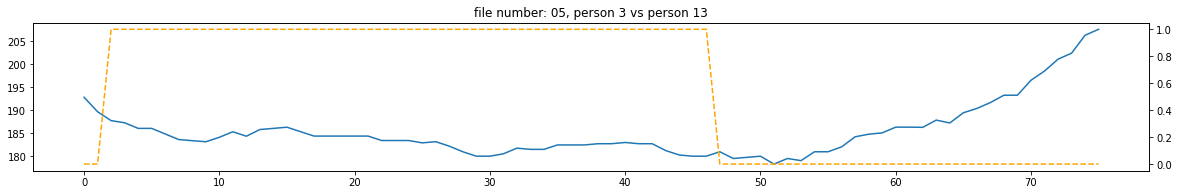

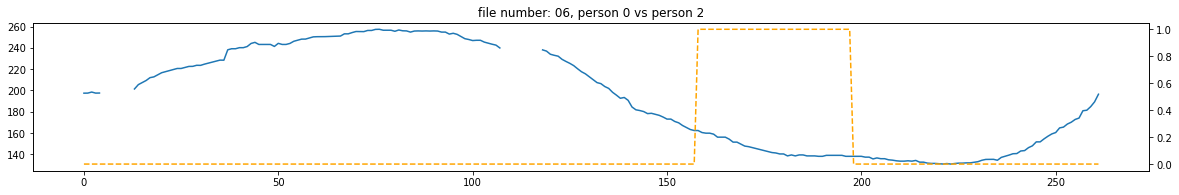

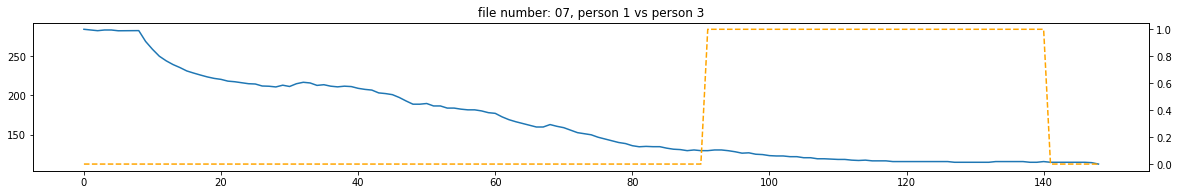

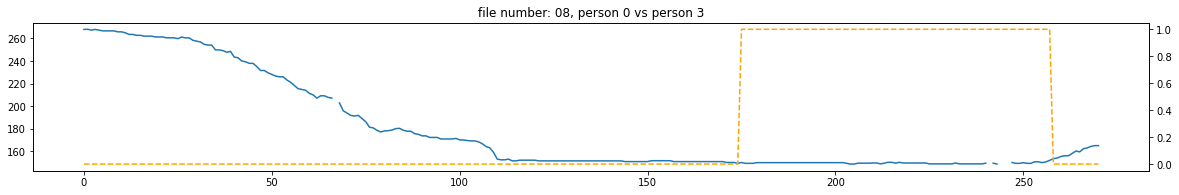

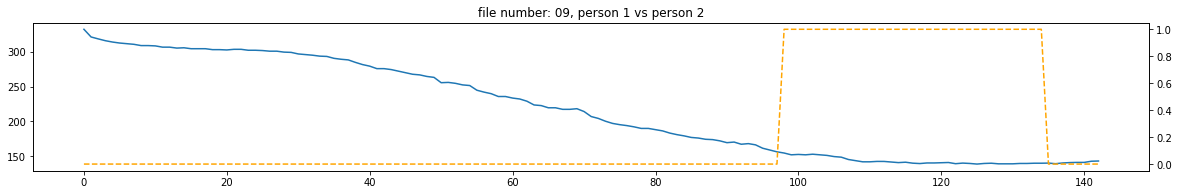

In [174]:
plot_time_series(dist_09, is_pass=1)

## 体の向き

In [175]:
def extract_time_series_body_direction(ia_lst, dirs, max_len=30):
    data = {}
    for individuals, path in list(zip(ia_lst, dirs)):
        csv_path = f'{path}/csv/data.csv'
        csv_data = np.loadtxt(csv_path, delimiter=',', dtype=int, skiprows=1)

        for row in csv_data:
            frame_num = row[0]
            p1 = row[1]
            p2 = row[2]
            
            key = path[-2:] + '_' + str(p1) + '_'  + str(p2)
            if key not in data:
                data[key] = {'is_pass': [], 'values':[]}
            values = data[key]

            values['is_pass'].append(row[3])
            val = calc_body_direction(frame_num, p1, p2, individuals)
            values['values'].append(val)
            
    del_lst = []
    for key, values in data.items():
        if len(values['values']) < max_len:
            del_lst.append(key)
            
    for key in del_lst:
        del data[key]

    return data


def extract_body_direction_time_series_all(room_num, date, max_len=30):
    dirs = glob.glob(f'{common.data_dir}/{room_num}/{date}/passing/*')
    dirs = sorted(dirs)[:-1]  # delete make_csv.

    # homography
    field_path = os.path.join(common.data_dir, '{}/field.png'.format(room_num))
    field_raw = cv2.imread(field_path)
    p_video = common.homo[room_num][0]
    p_field = common.homo[room_num][1]
    homo = transform.Homography(p_video, p_field, field_raw.shape)

    ia_lst = []
    for path in dirs:
        path = f'{path}/json/individual_activity.json'
        json_data = json.load(path)
        individuals = make_individuals(json_data, homo)
        ia_lst.append(individuals)

    data = extract_time_series_body_direction(ia_lst, dirs, max_len)
    
    return data

In [178]:
bd_02 = extract_body_direction_time_series_all('02','20210903')

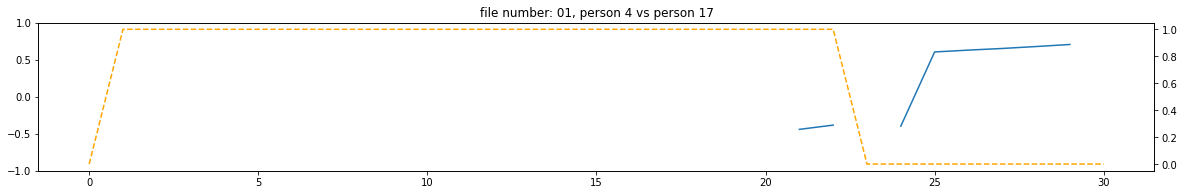

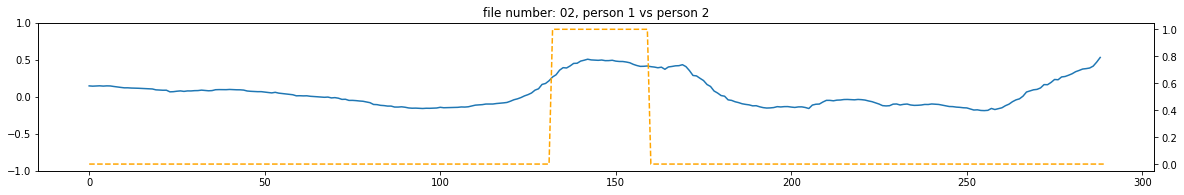

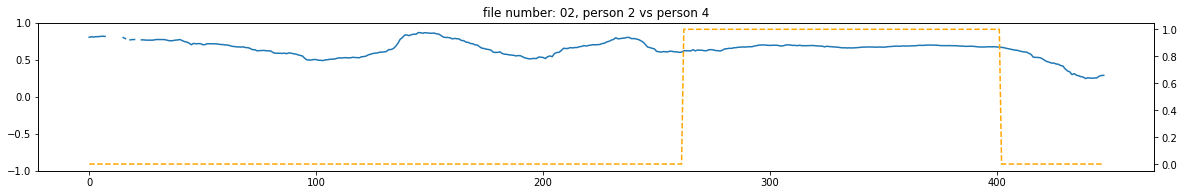

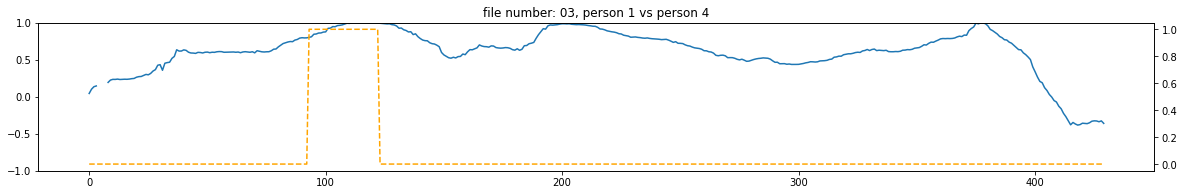

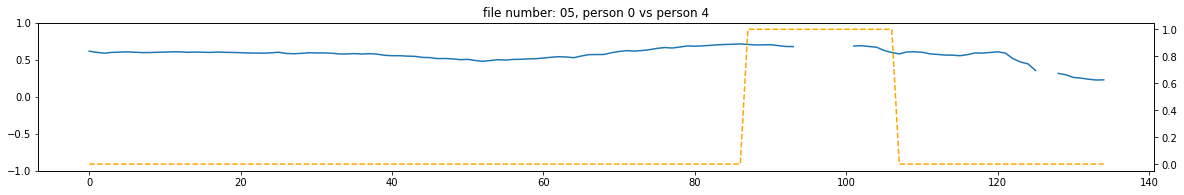

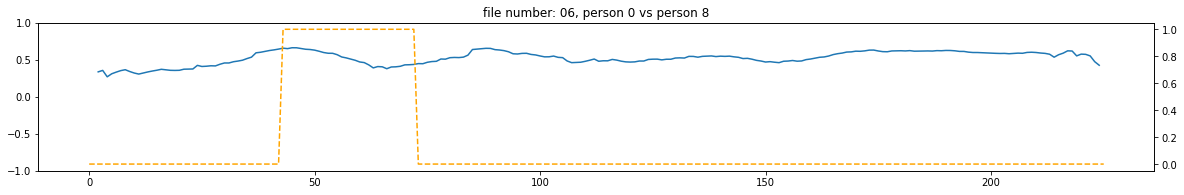

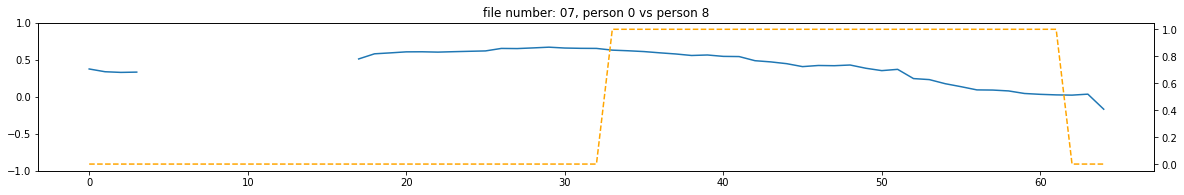

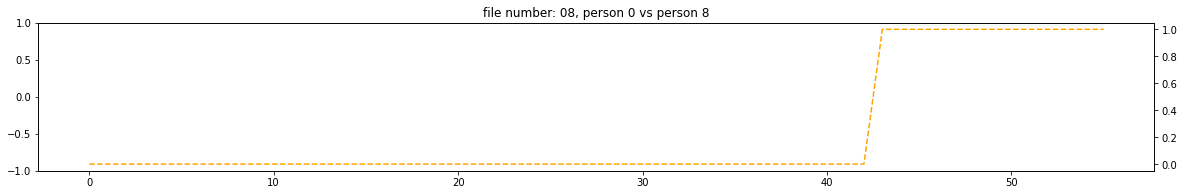

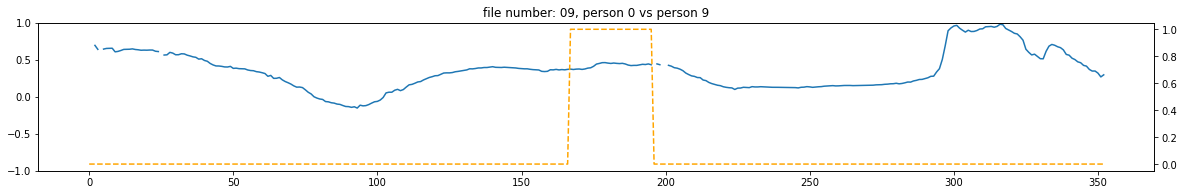

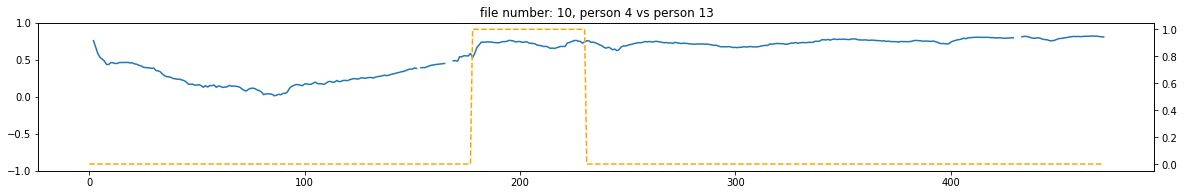

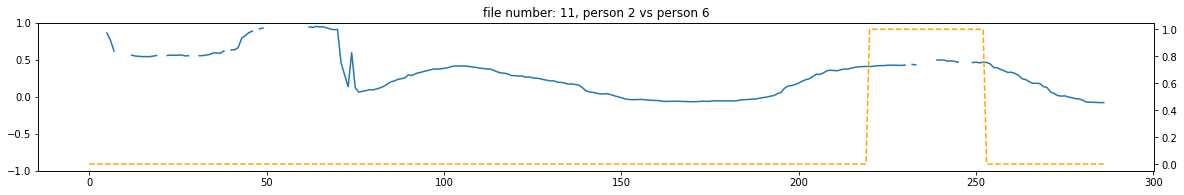

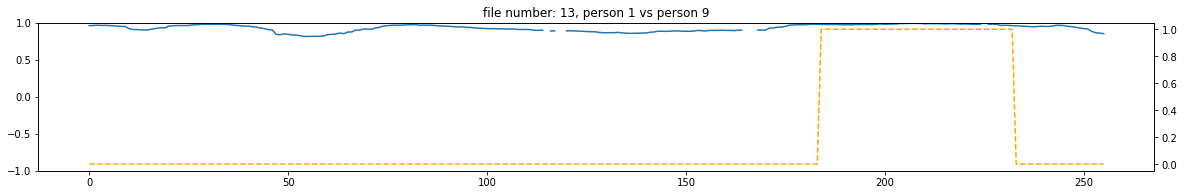

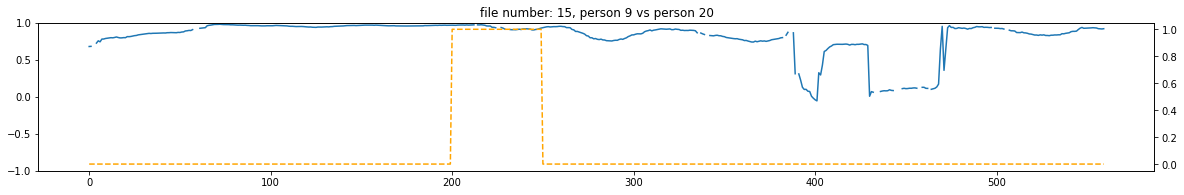

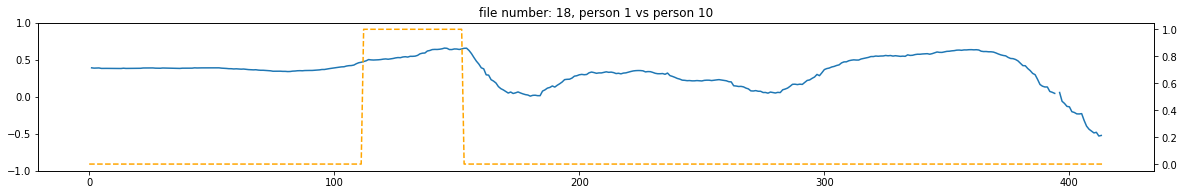

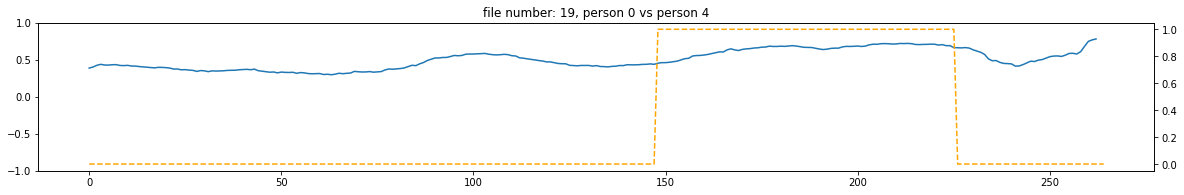

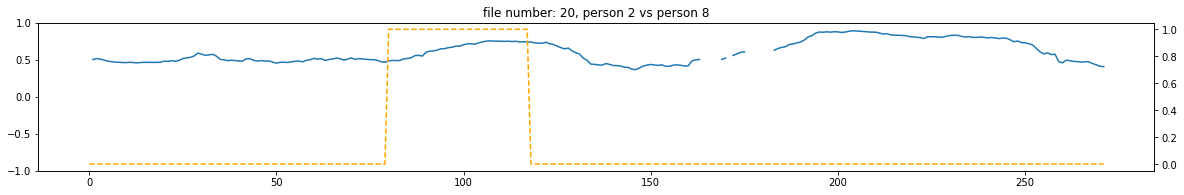

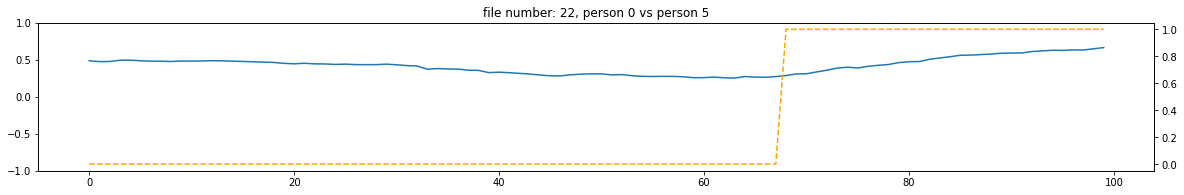

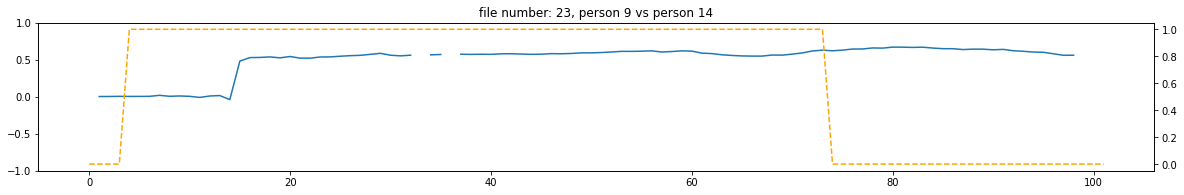

In [185]:
plot_time_series(bd_02, is_pass=1, ylim=(-1, 1))

In [180]:
bd_08 = extract_body_direction_time_series_all('08','20210915')

/tmp/ipykernel_3989/1677506860.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(20, 6))


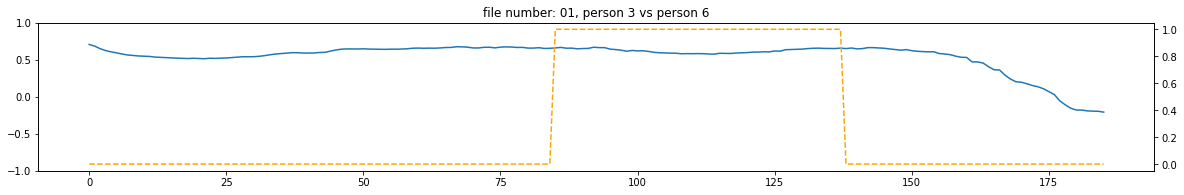

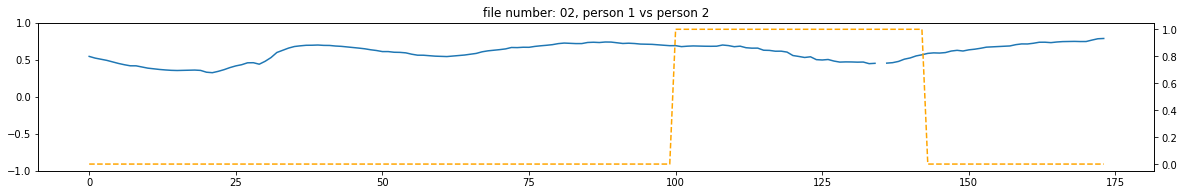

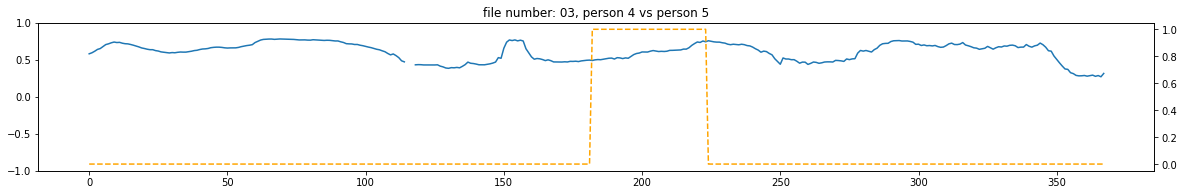

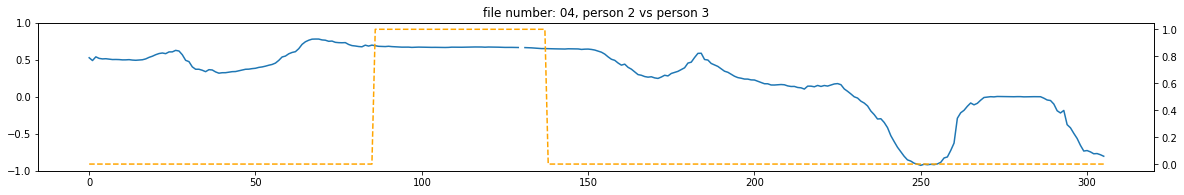

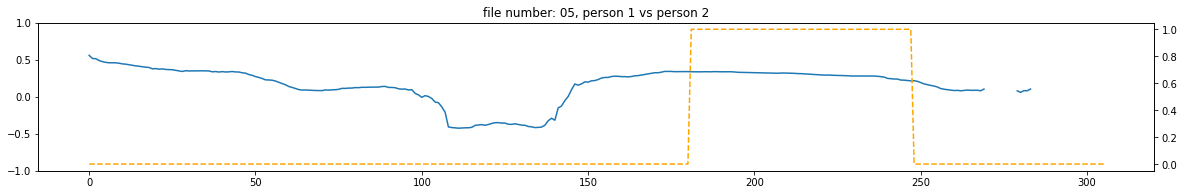

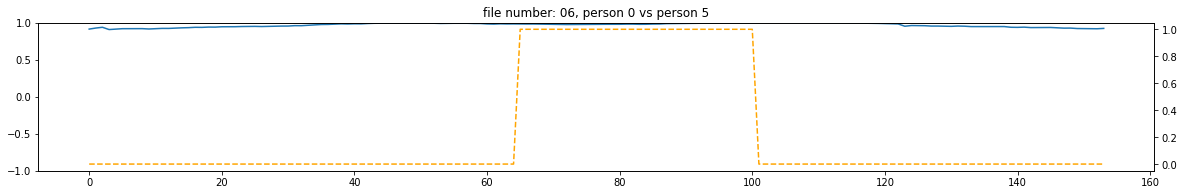

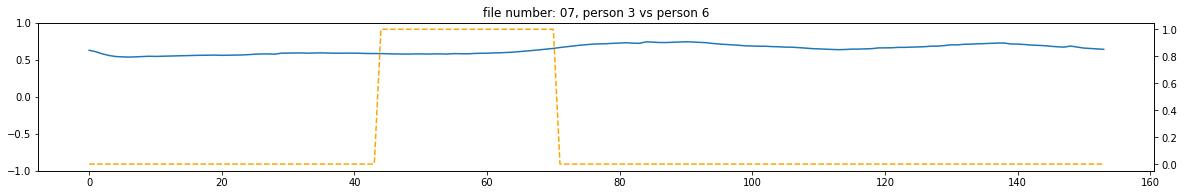

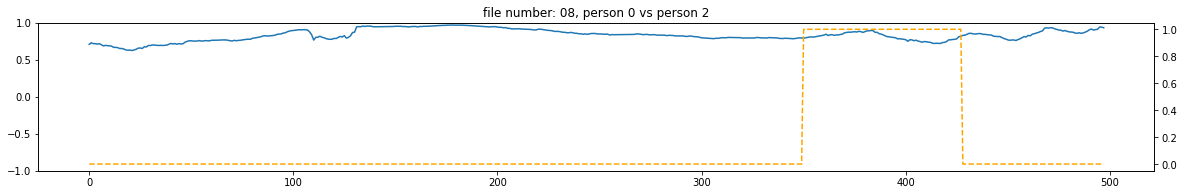

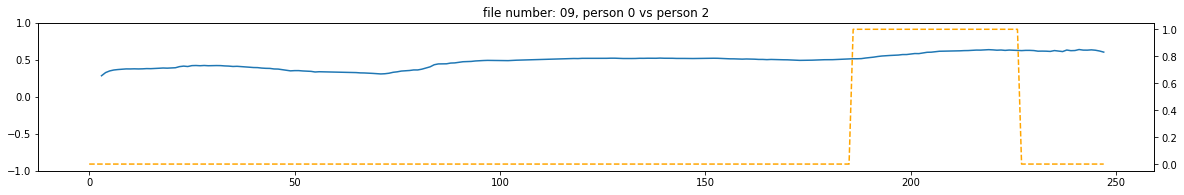

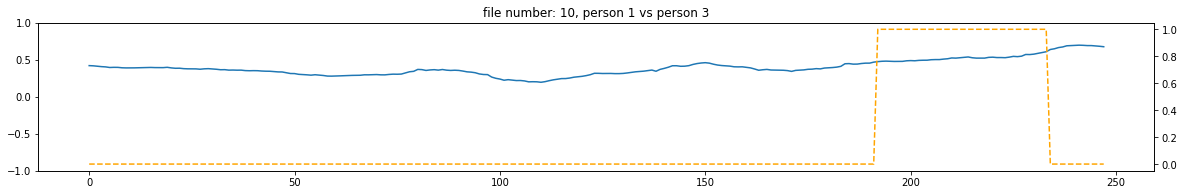

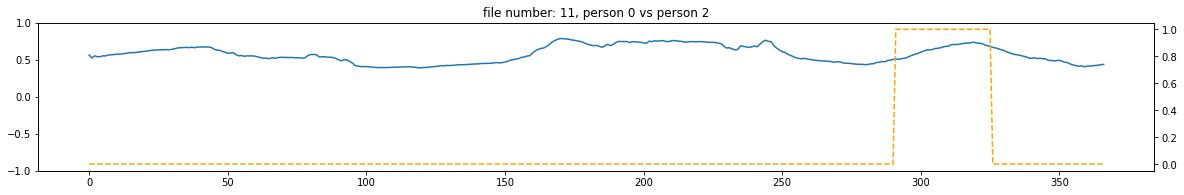

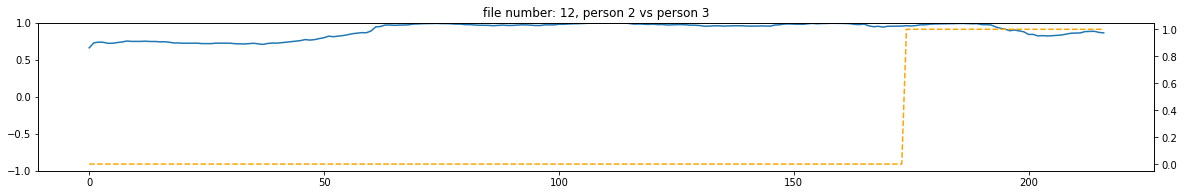

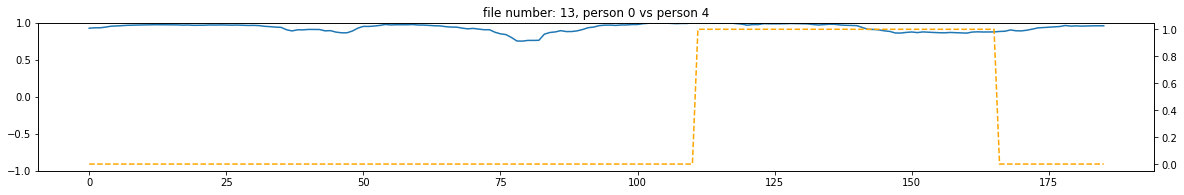

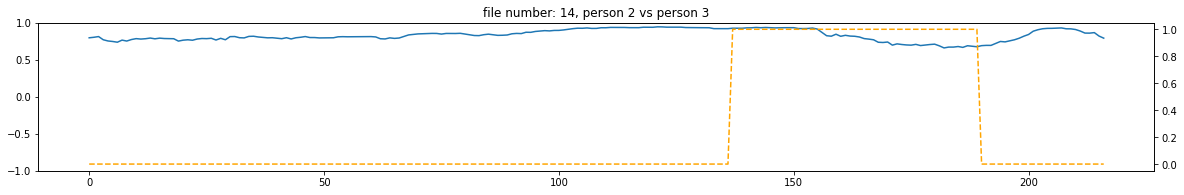

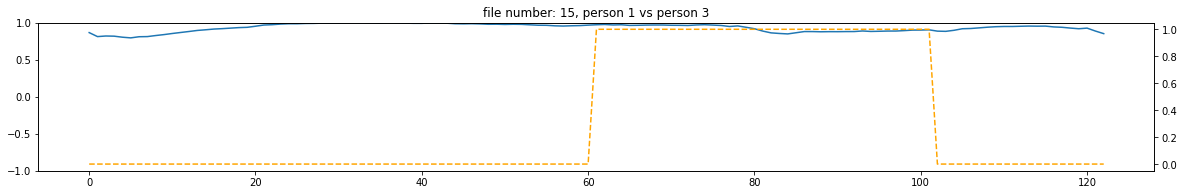

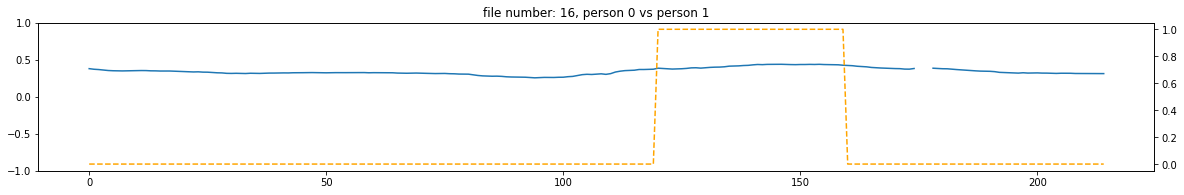

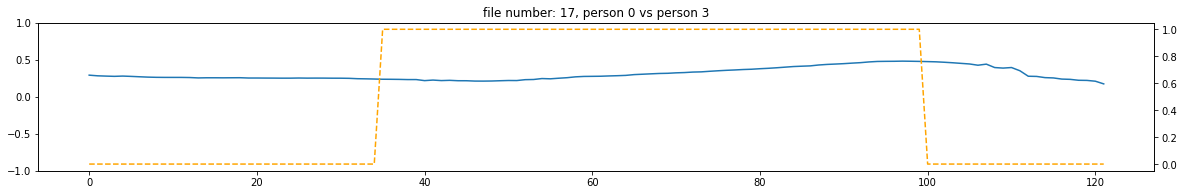

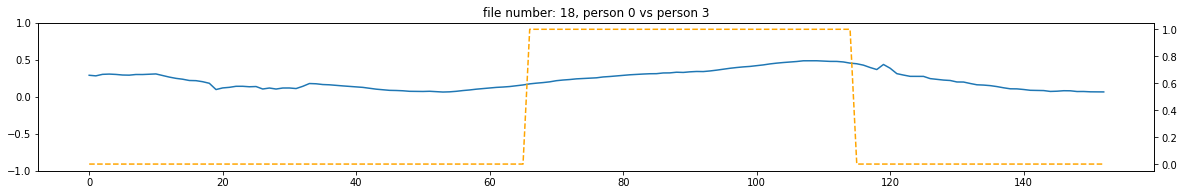

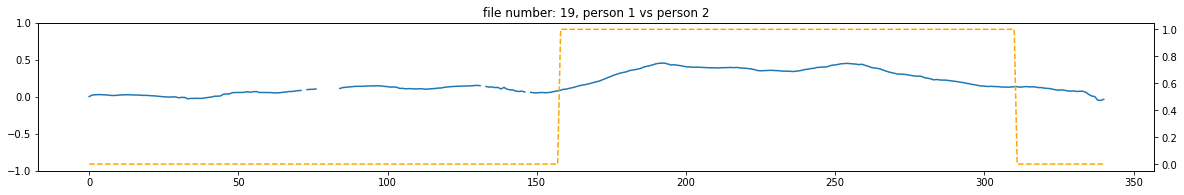

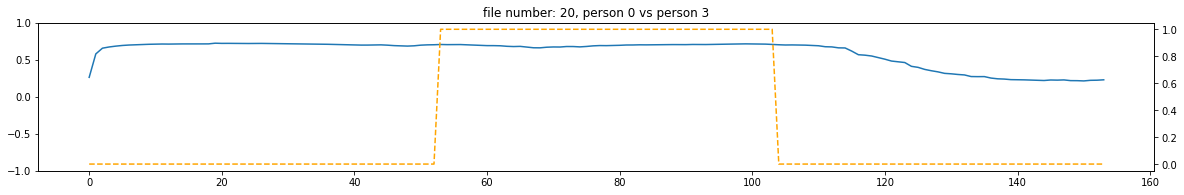

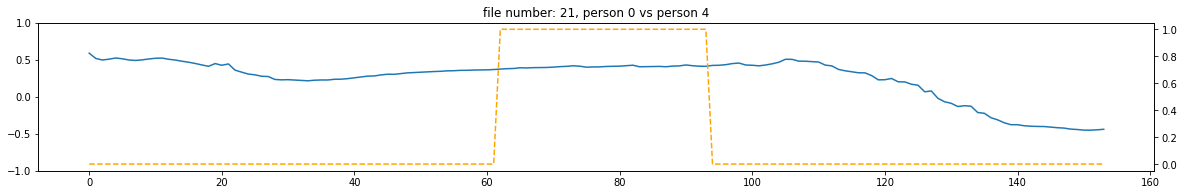

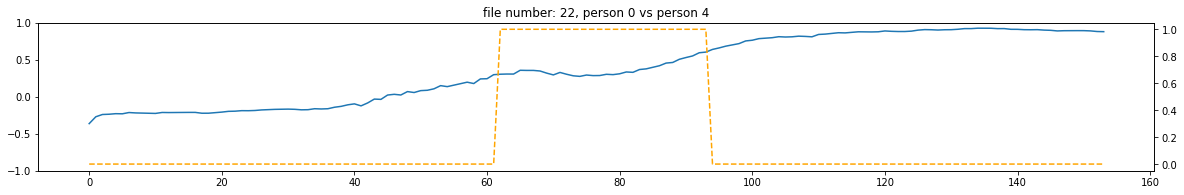

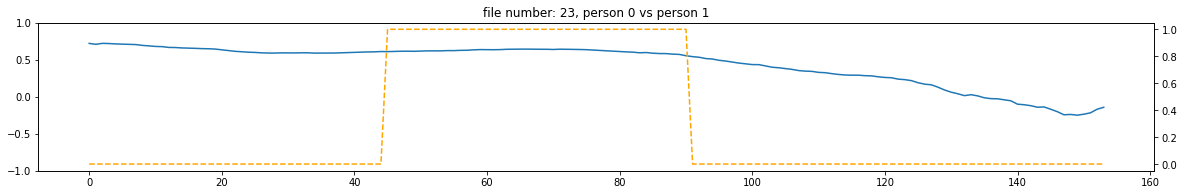

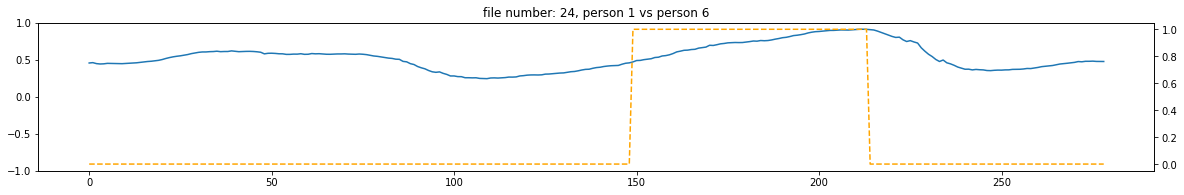

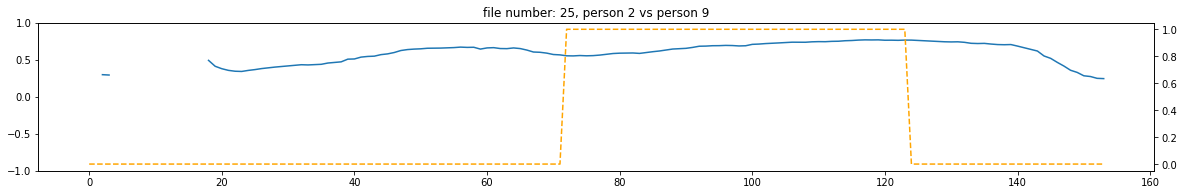

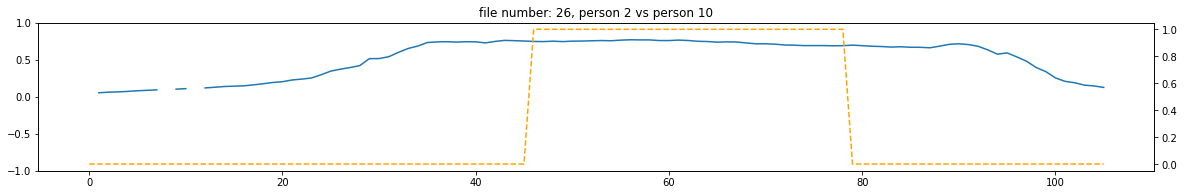

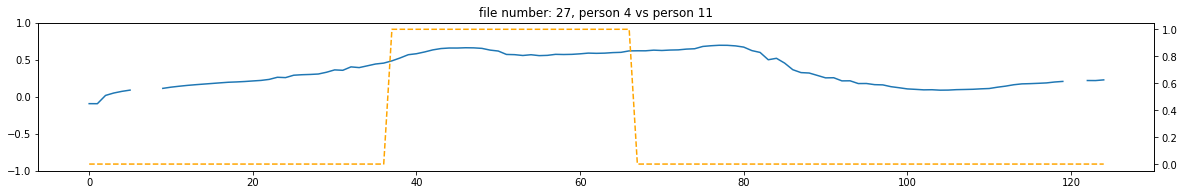

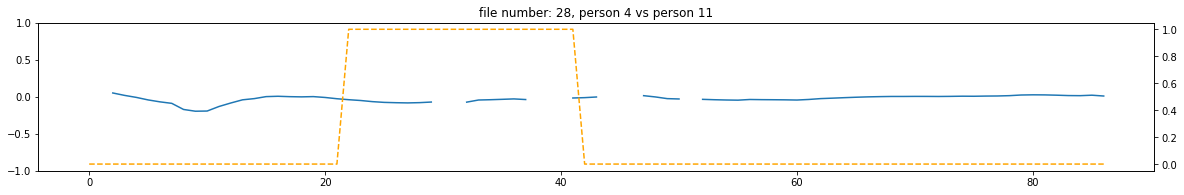

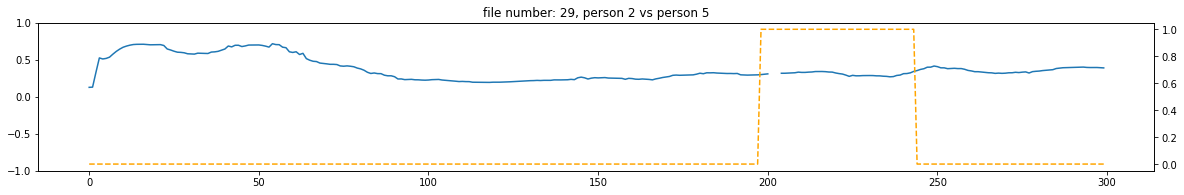

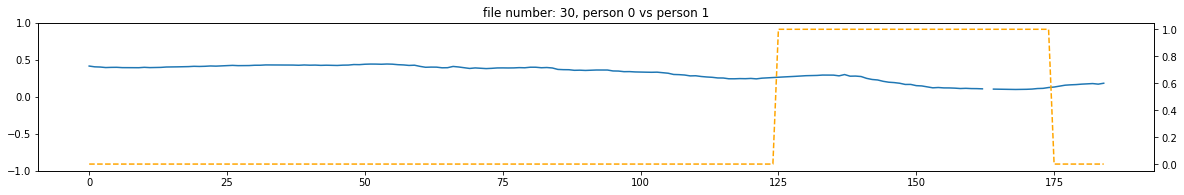

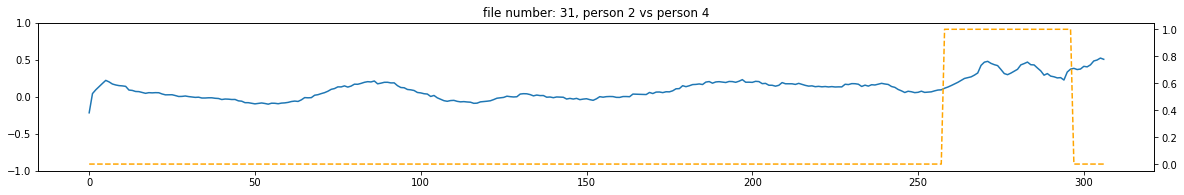

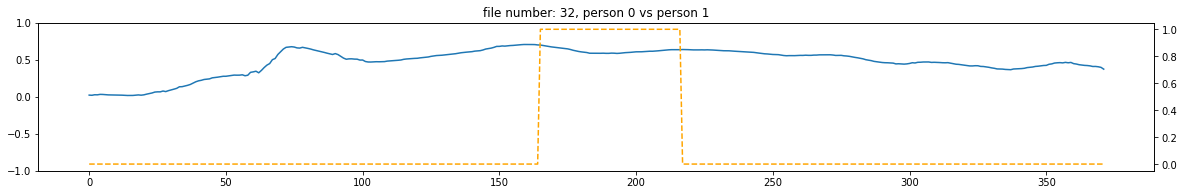

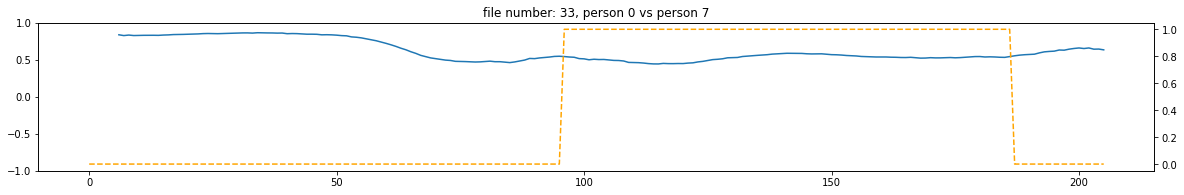

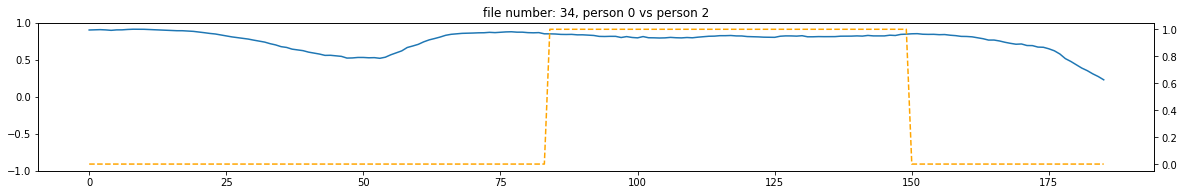

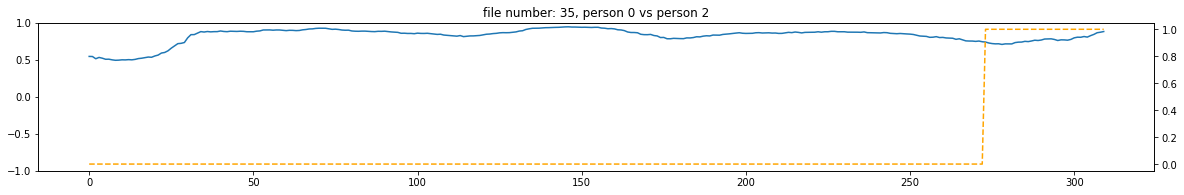

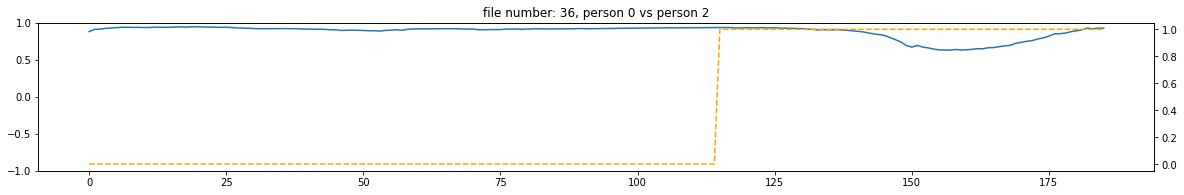

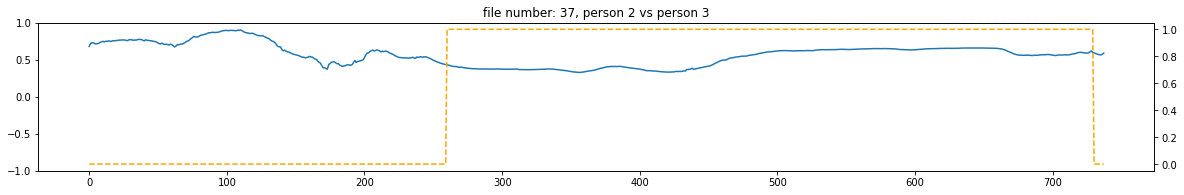

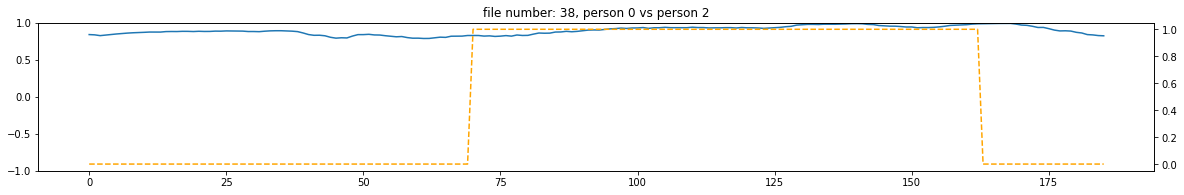

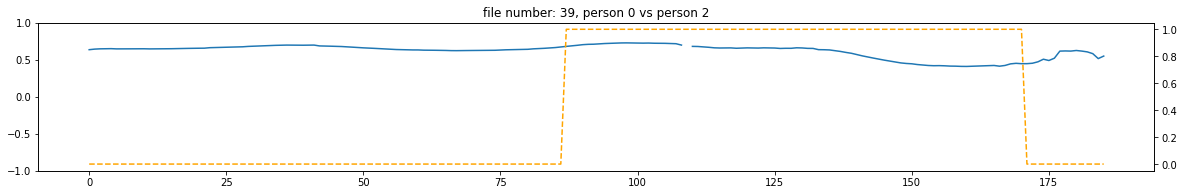

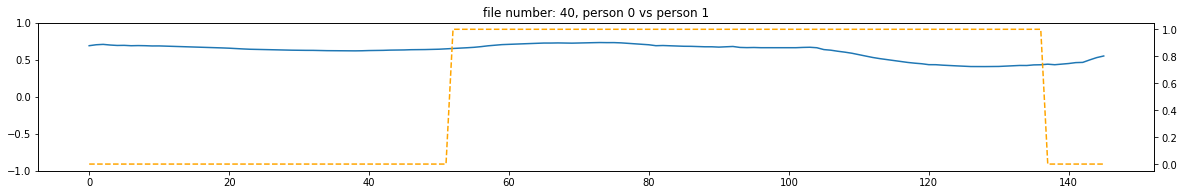

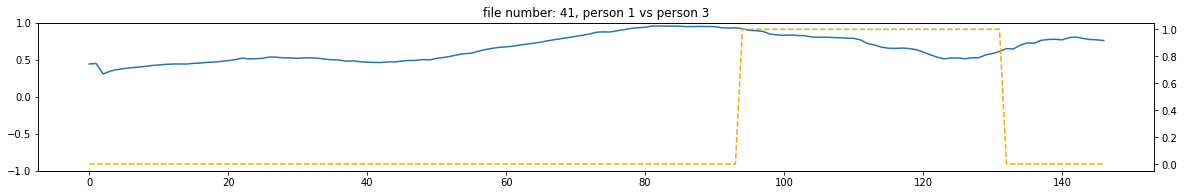

In [187]:
plot_time_series(bd_08, is_pass=1, ylim=(-1, 1))

In [182]:
bd_09 = extract_body_direction_time_series_all('09','20210706')

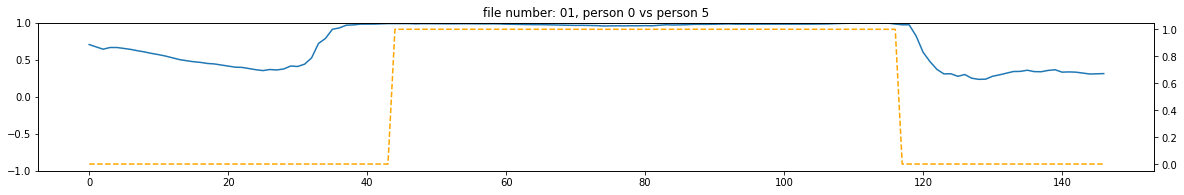

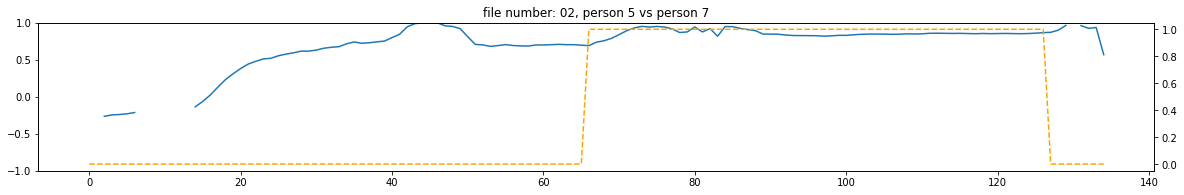

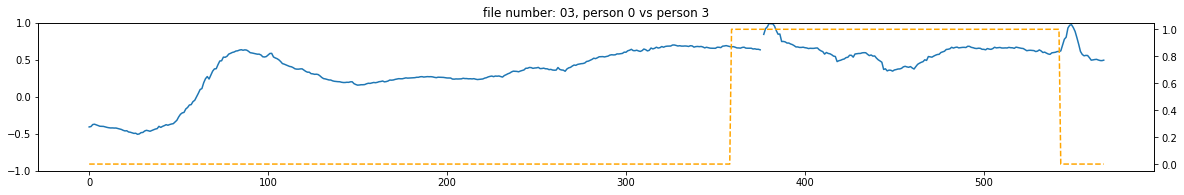

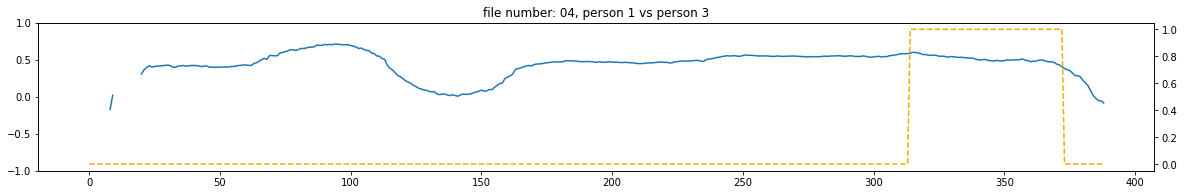

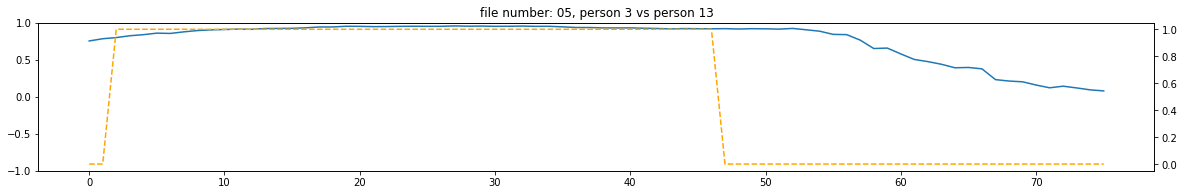

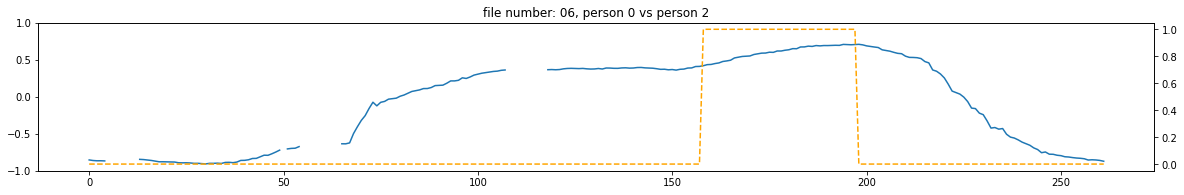

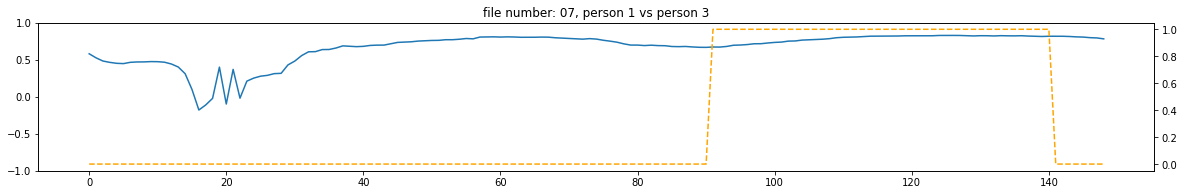

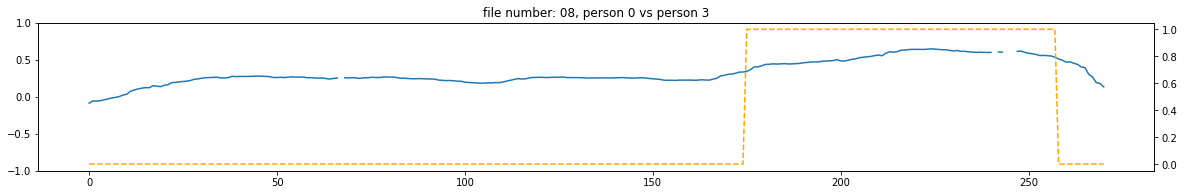

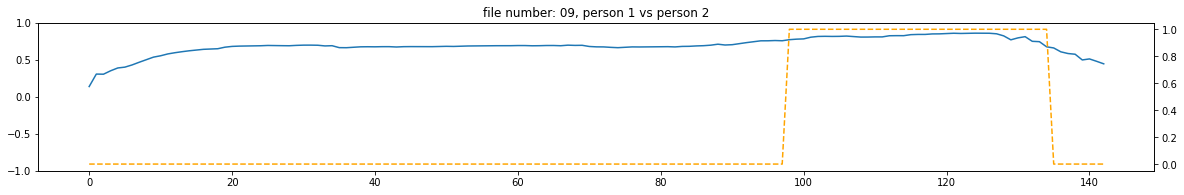

In [186]:
plot_time_series(bd_09, is_pass=1, ylim=(-1, 1))

## 腕の上げ下げ

In [188]:
def extract_time_series_arm(ia_lst, dirs, max_len=30):
    data = {}
    for individuals, path in list(zip(ia_lst, dirs)):
        csv_path = f'{path}/csv/data.csv'
        csv_data = np.loadtxt(csv_path, delimiter=',', dtype=int, skiprows=1)

        for row in csv_data:
            frame_num = row[0]
            p1 = row[1]
            p2 = row[2]
            
            key = path[-2:] + '_' + str(p1) + '_'  + str(p2)
            if key not in data:
                data[key] = {'is_pass': [], 'values':[]}
            values = data[key]

            values['is_pass'].append(row[3])
            val = calc_arm(frame_num, p1, p2, individuals)
            values['values'].append(val)
            
    del_lst = []
    for key, values in data.items():
        if len(values['values']) < max_len:
            del_lst.append(key)
            
    for key in del_lst:
        del data[key]

    return data


def extract_arm_time_series_all(room_num, date, max_len=30):
    dirs = glob.glob(f'{common.data_dir}/{room_num}/{date}/passing/*')
    dirs = sorted(dirs)[:-1]  # delete make_csv.

    # homography
    field_path = os.path.join(common.data_dir, '{}/field.png'.format(room_num))
    field_raw = cv2.imread(field_path)
    p_video = common.homo[room_num][0]
    p_field = common.homo[room_num][1]
    homo = transform.Homography(p_video, p_field, field_raw.shape)

    ia_lst = []
    for path in dirs:
        path = f'{path}/json/individual_activity.json'
        json_data = json.load(path)
        individuals = make_individuals(json_data, homo)
        ia_lst.append(individuals)

    data = extract_time_series_arm(ia_lst, dirs, max_len)
    
    return data

In [189]:
arm_02 = extract_arm_time_series_all('02','20210903')

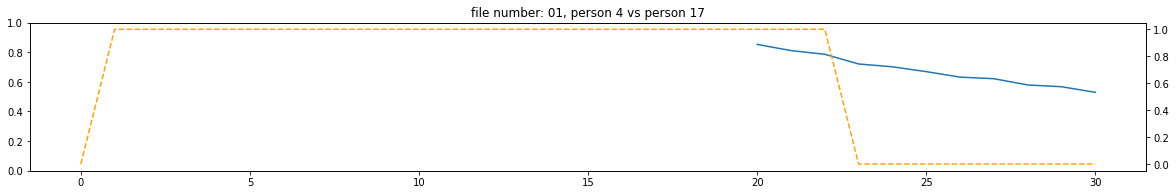

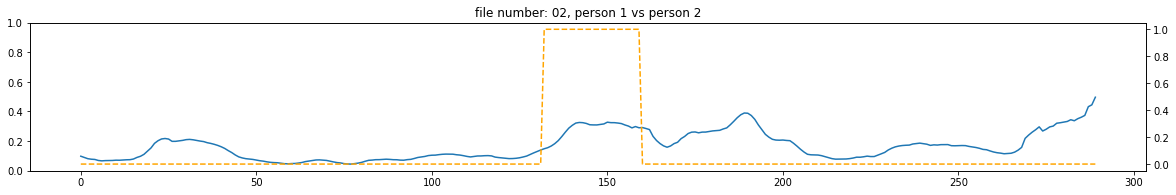

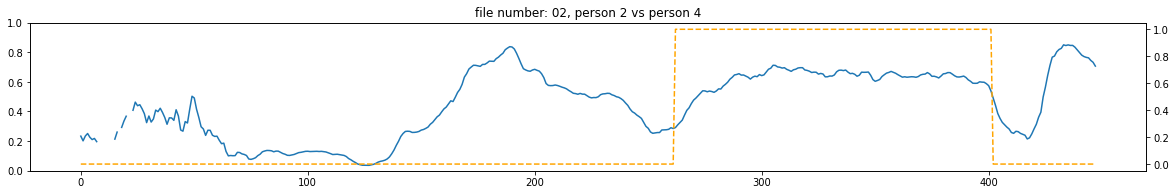

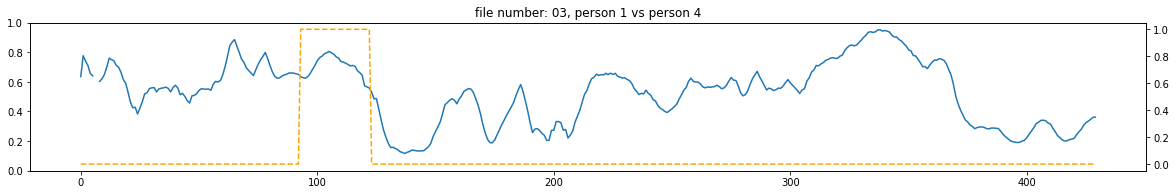

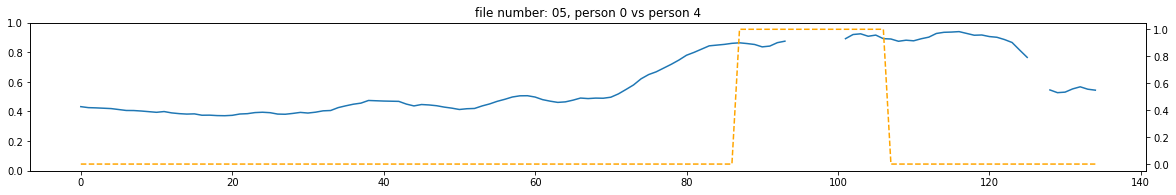

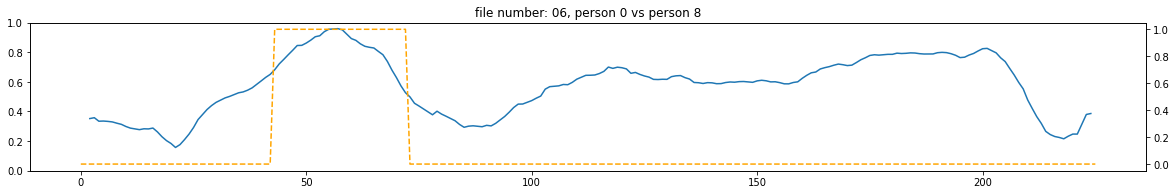

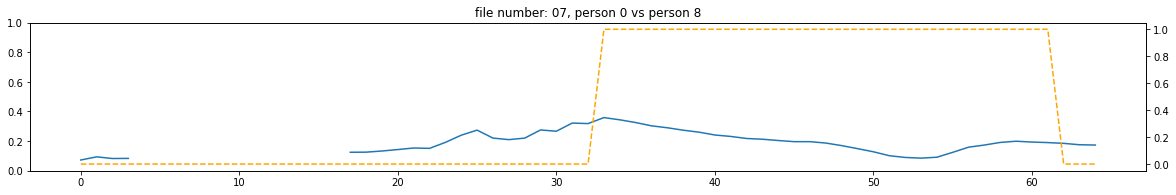

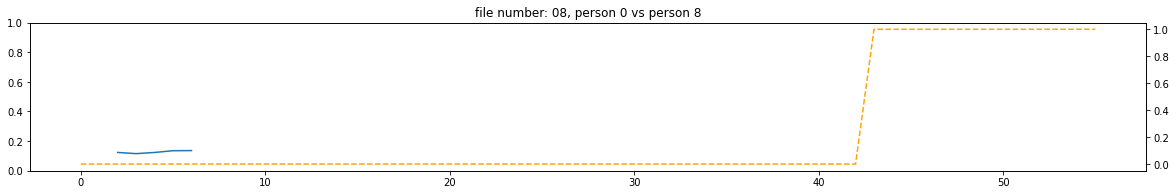

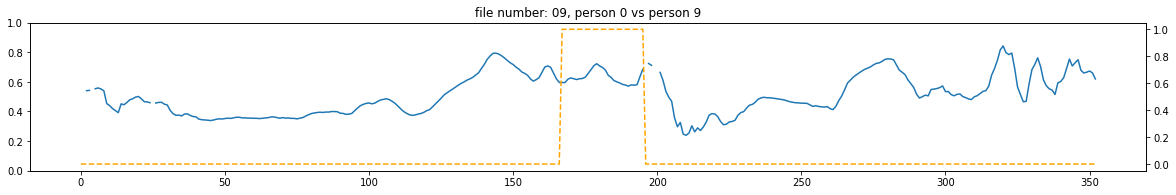

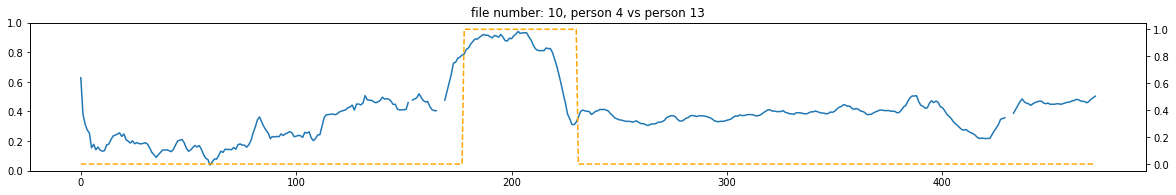

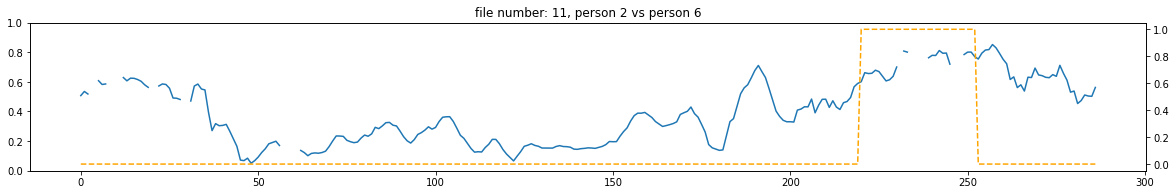

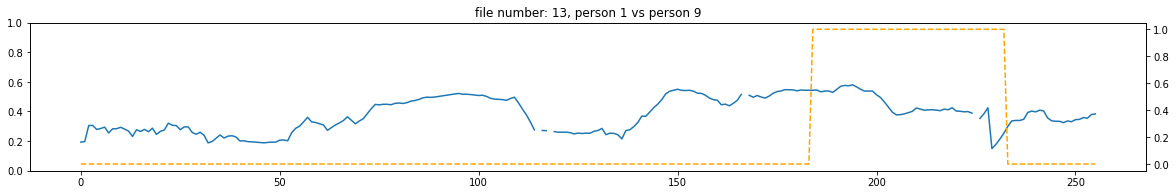

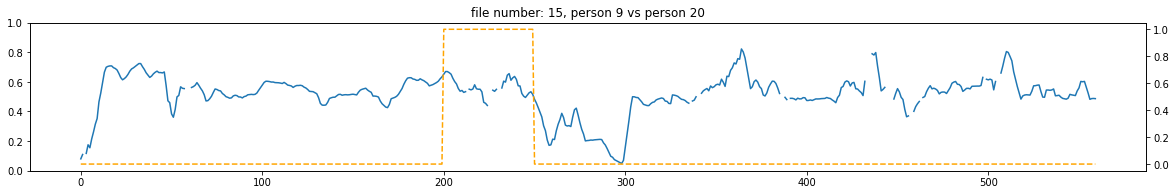

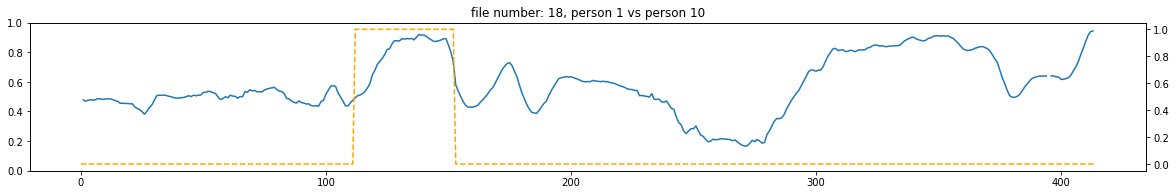

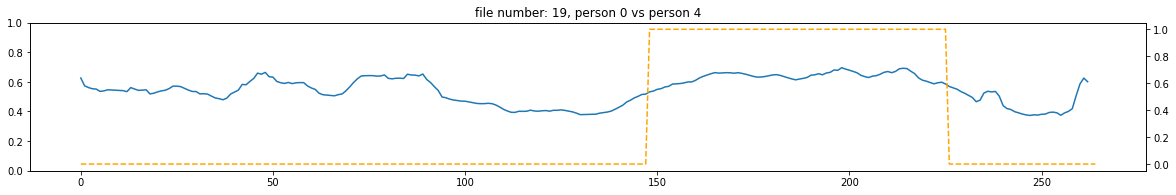

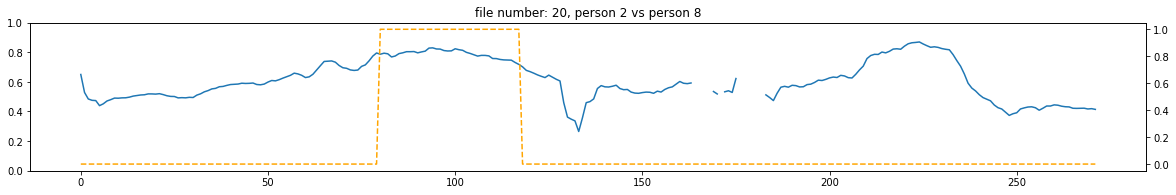

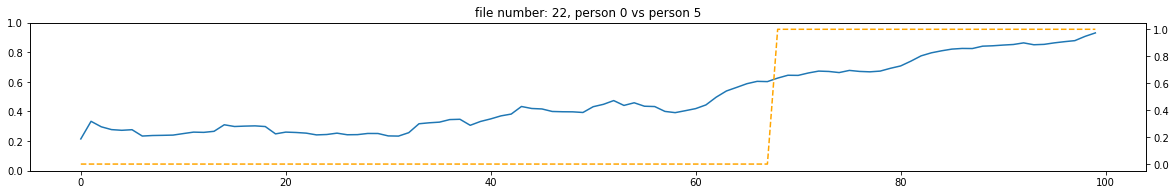

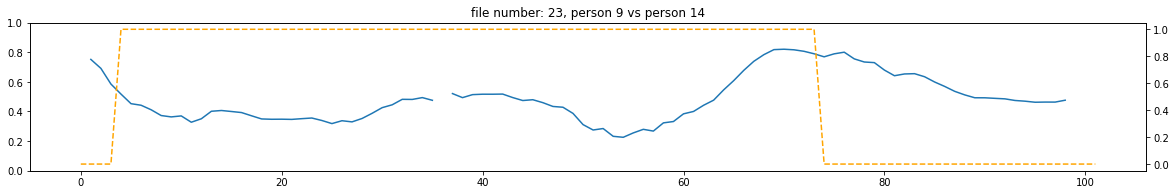

In [190]:
plot_time_series(arm_02, is_pass=1, ylim=(0, 1))

In [191]:
arm_08 = extract_arm_time_series_all('08','20210915')

/tmp/ipykernel_3989/1677506860.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(20, 6))


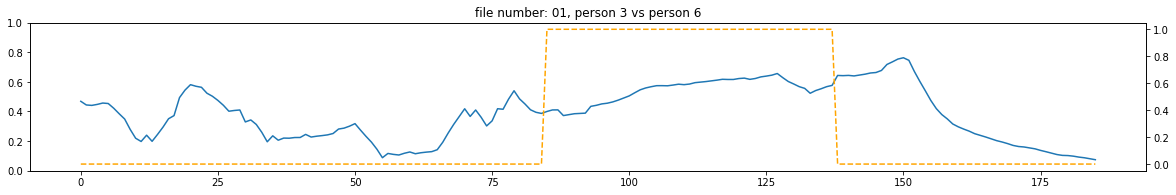

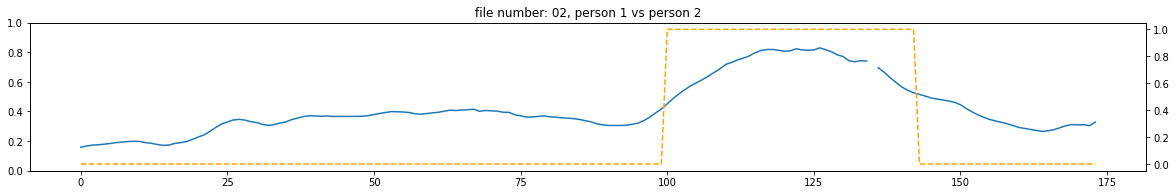

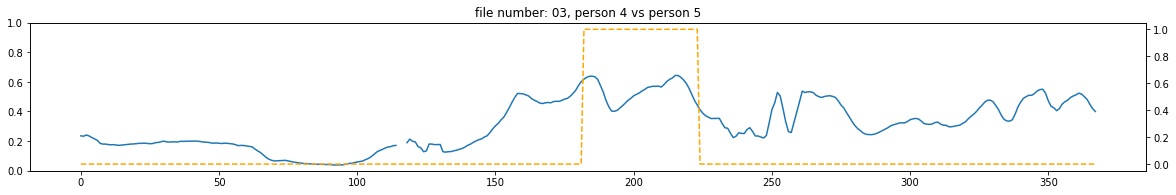

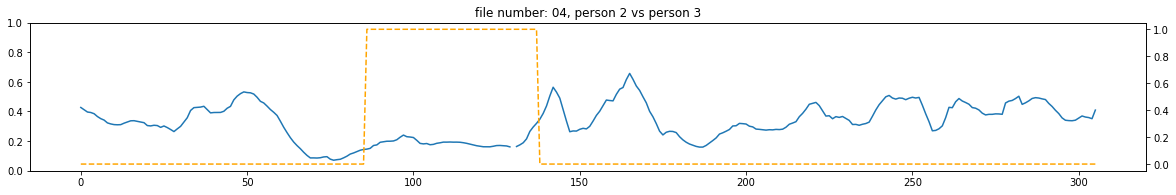

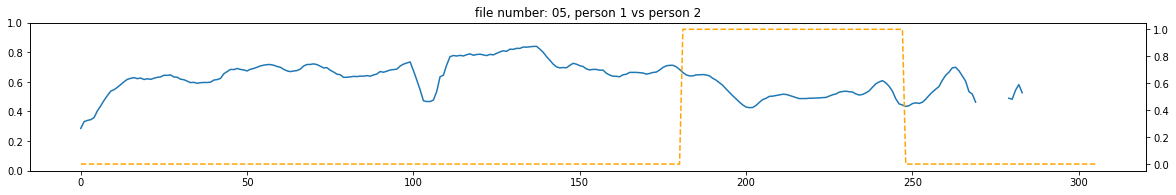

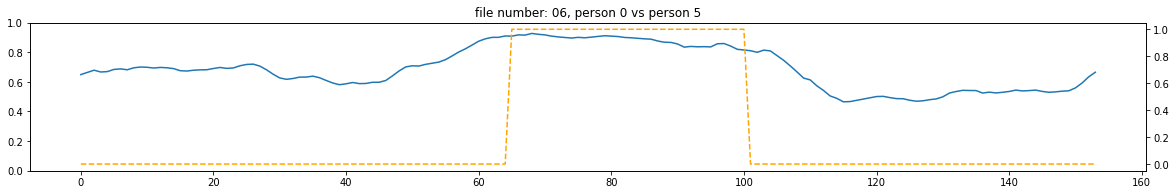

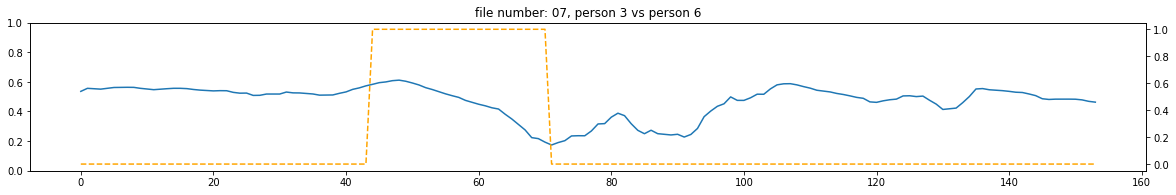

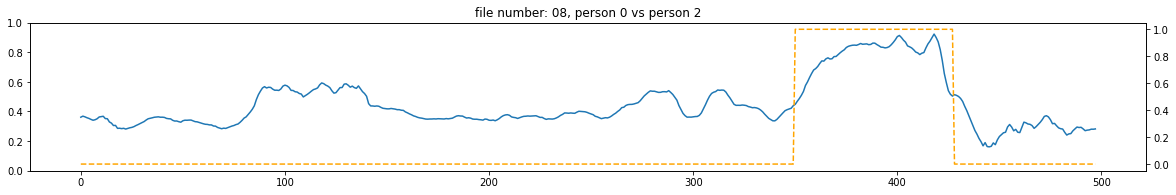

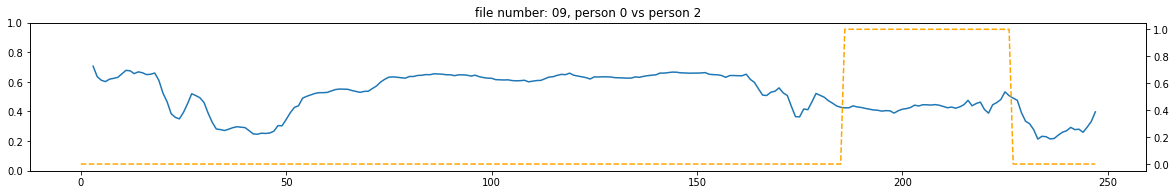

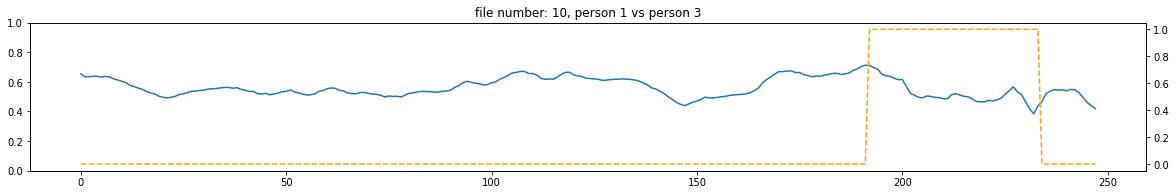

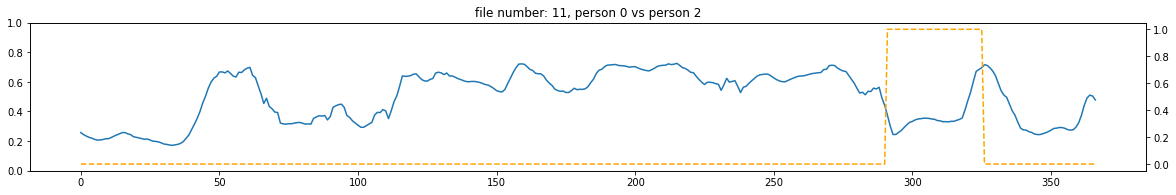

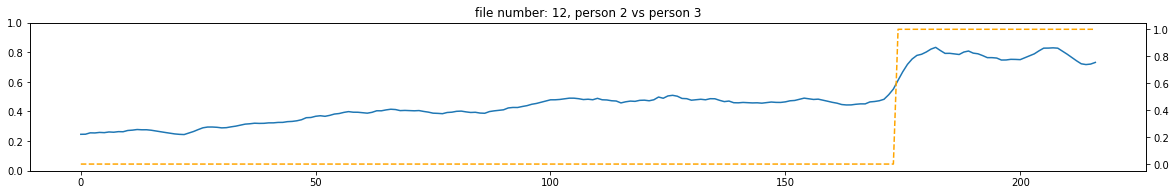

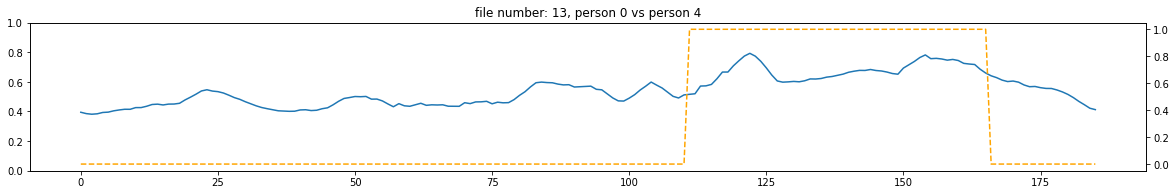

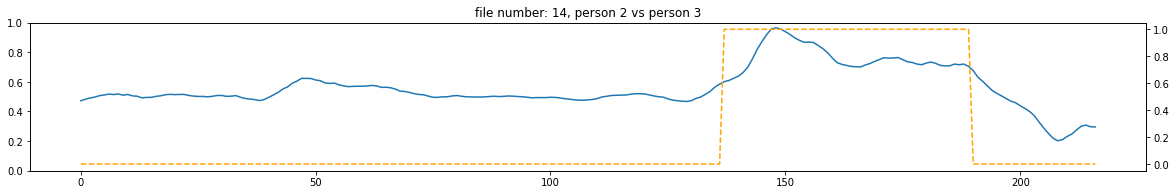

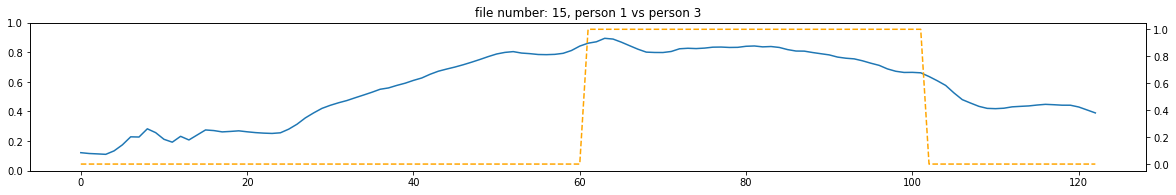

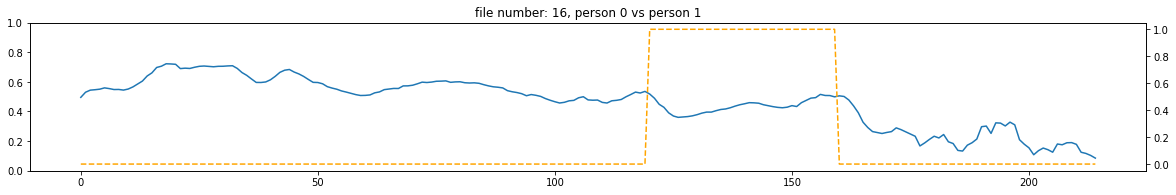

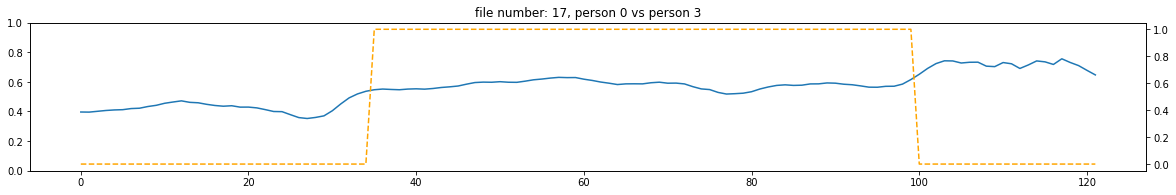

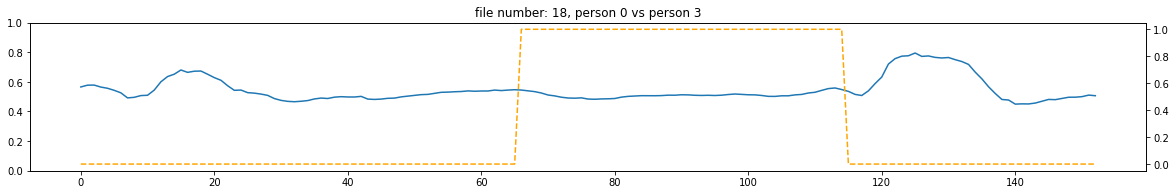

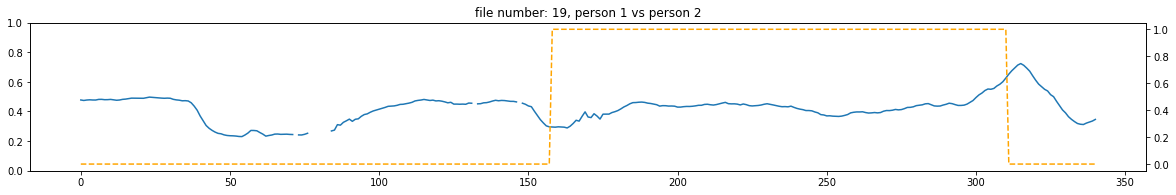

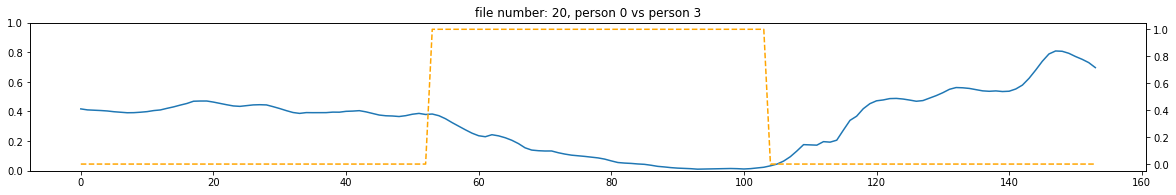

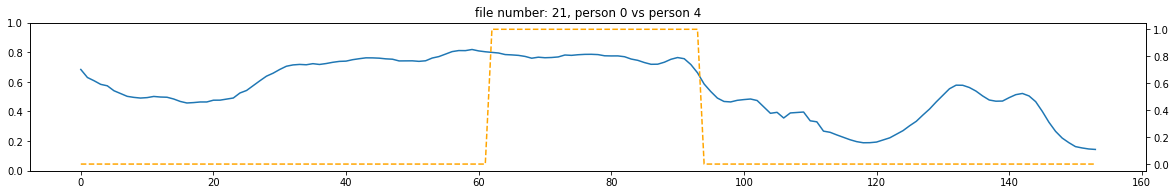

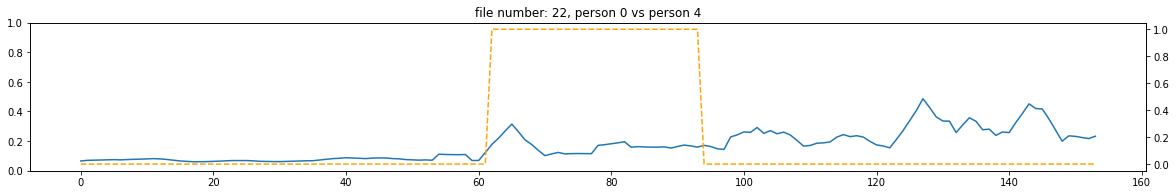

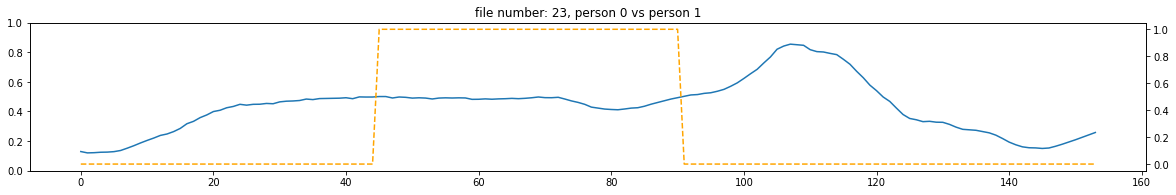

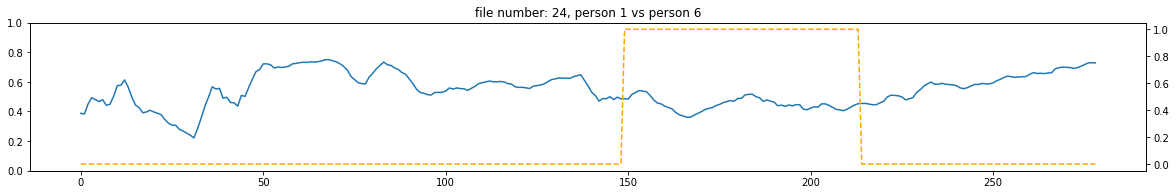

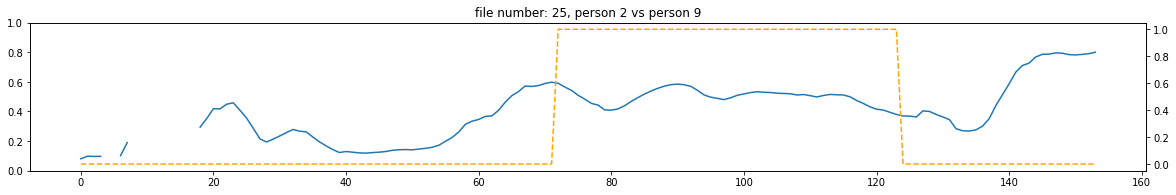

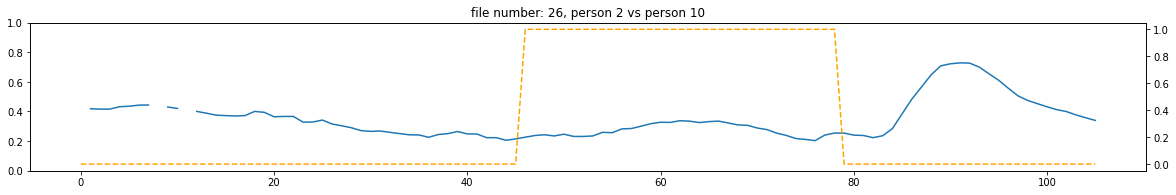

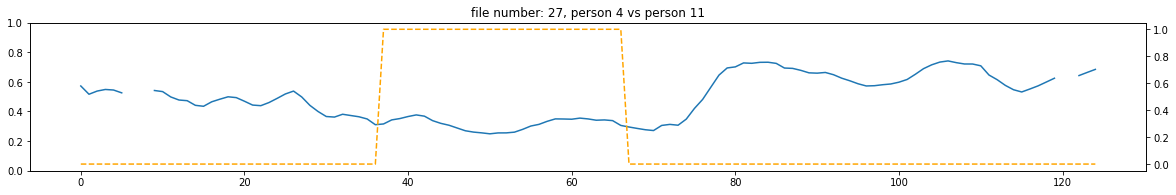

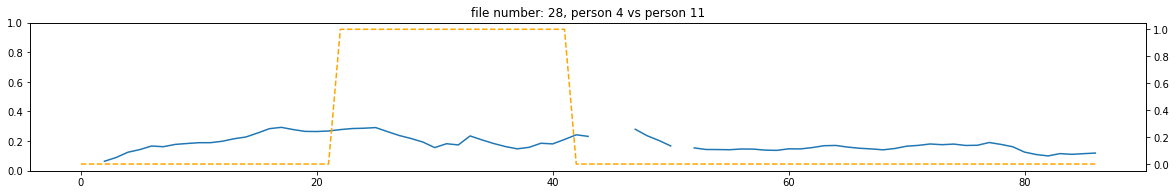

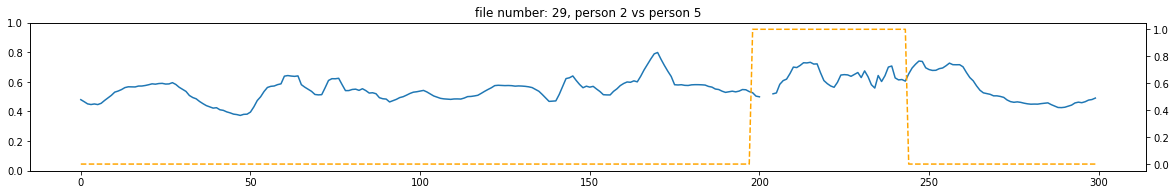

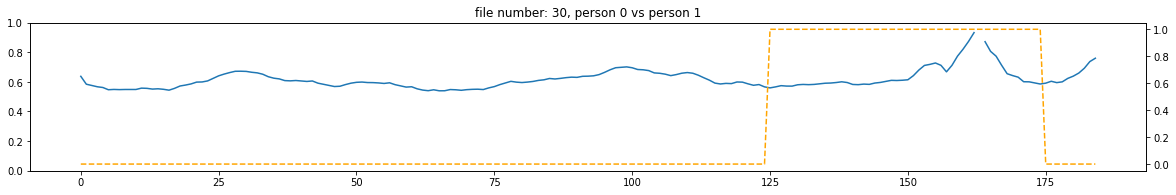

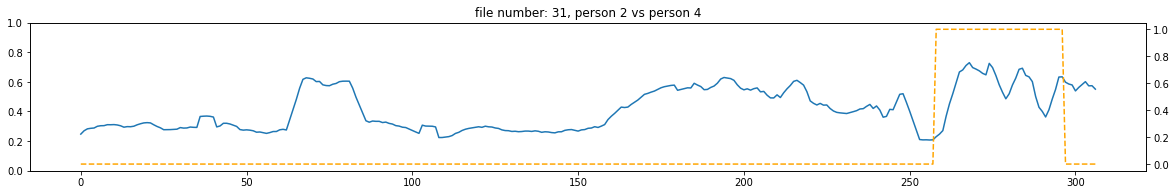

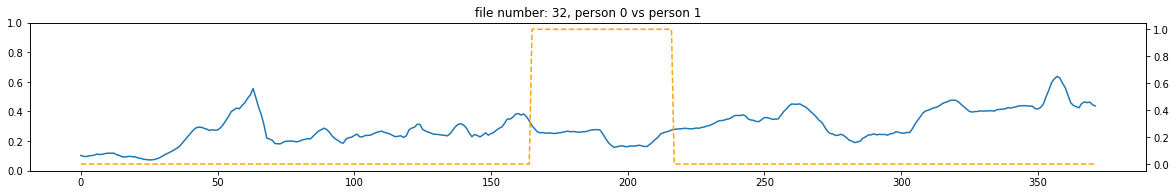

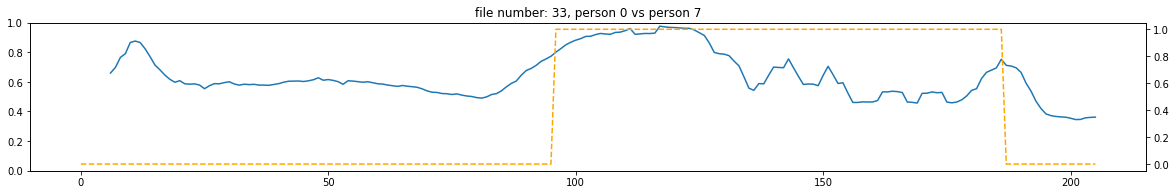

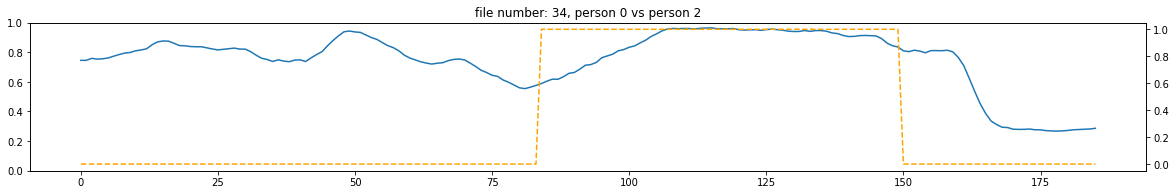

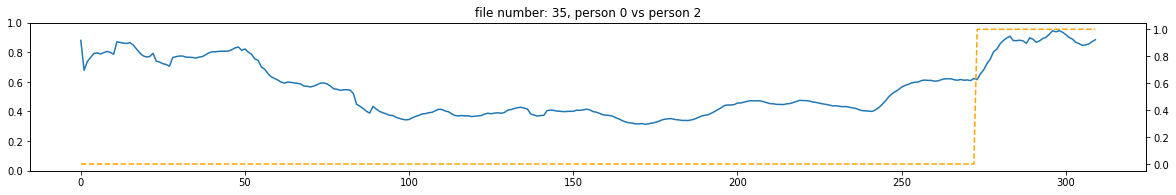

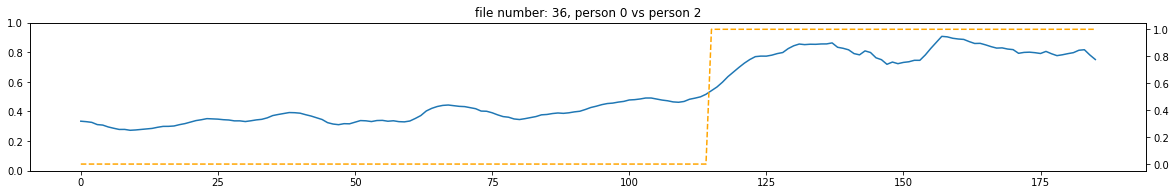

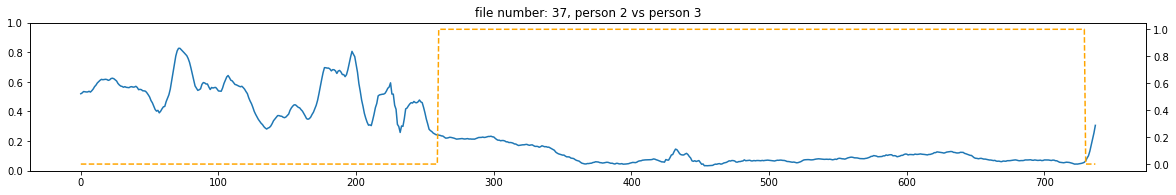

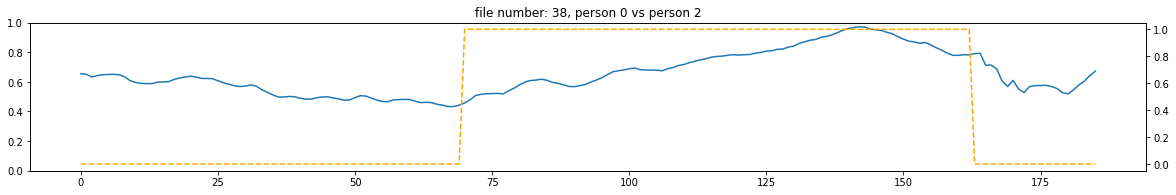

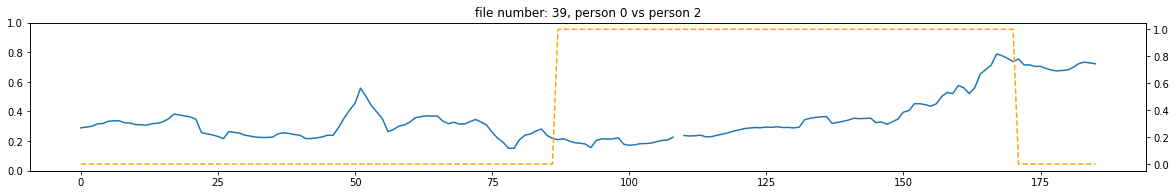

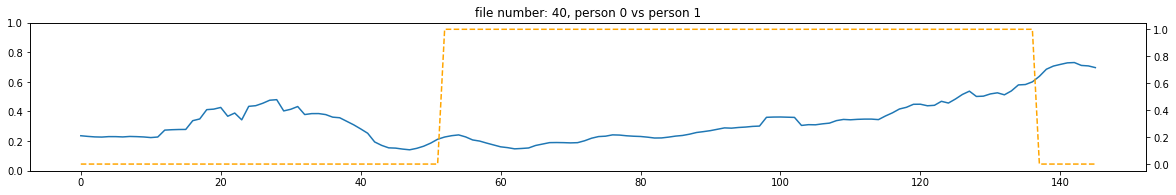

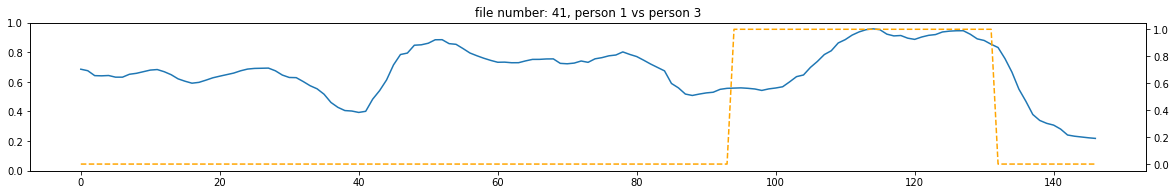

In [192]:
plot_time_series(arm_08, is_pass=1, ylim=(0, 1))

In [193]:
arm_09 = extract_arm_time_series_all('09','20210706')

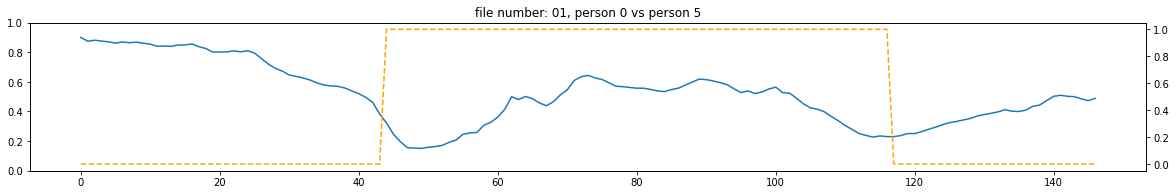

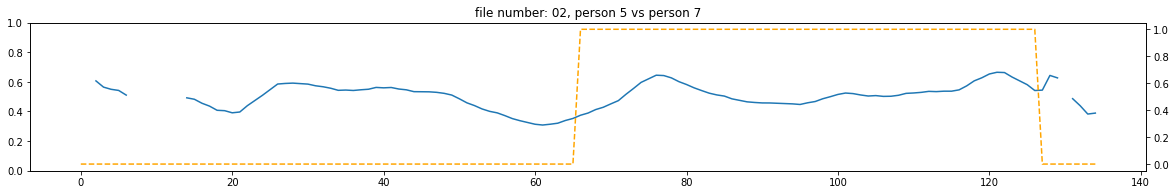

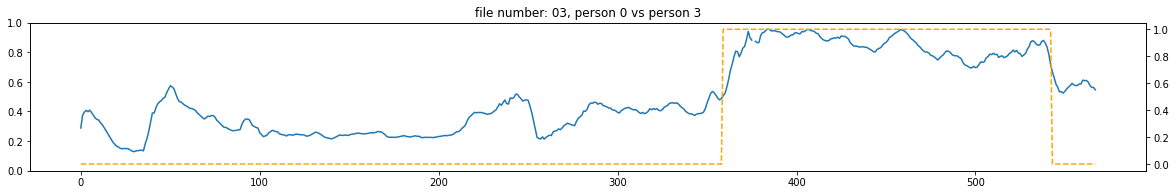

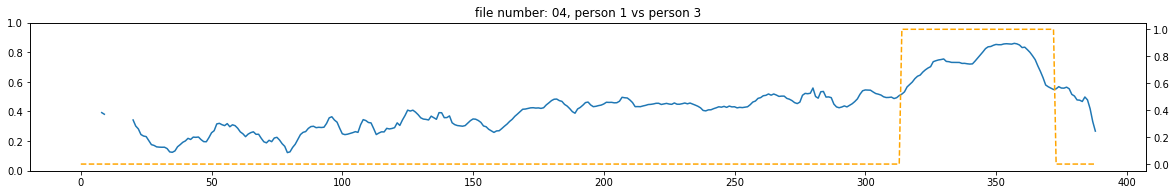

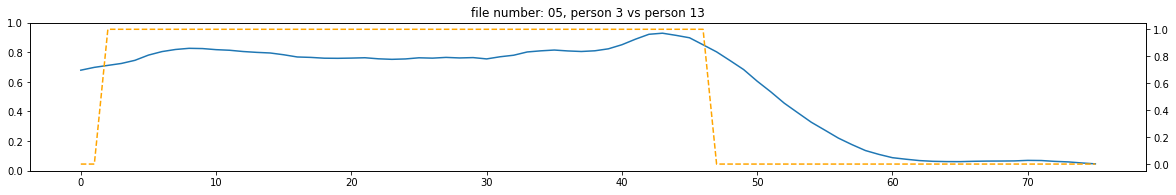

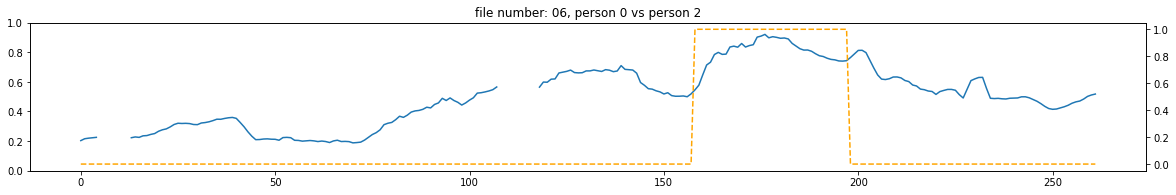

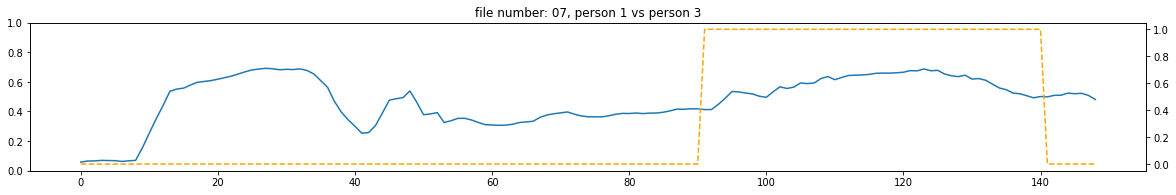

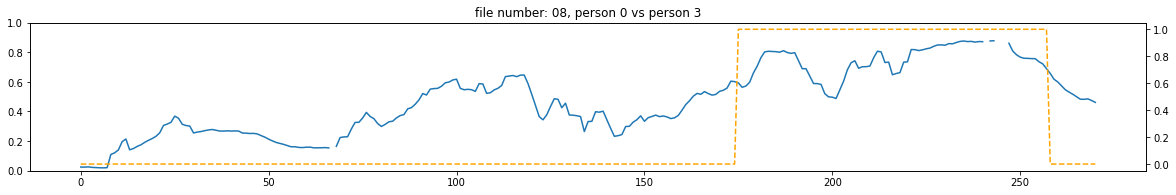

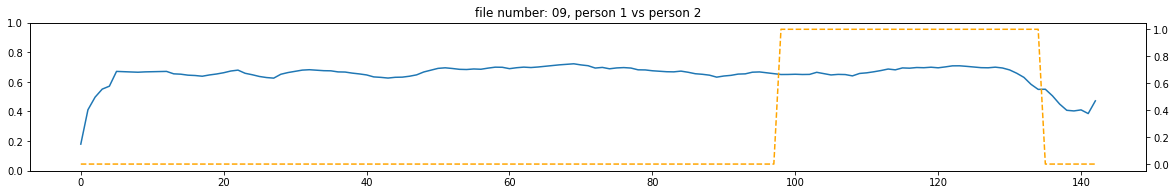

In [194]:
plot_time_series(arm_09, is_pass=1, ylim=(0, 1))

# データセットを作成

In [ ]:
def extract_features(frame_num, label1, label2, individuals):
    id1 = individuals[label1]
    kp1 = id1.keypoints[frame_num]
    
    id2 = individuals[label2]
    kp2 = id2.keypoints[frame_num]
    
    feature = []
    for p1 in kp1:
        row = []
        for p2 in kp2:
            if p1 is None or p2 is None:
                row.append(0)
            else:
                row.append(np.linalg.norm(np.array(p1) - np.array(p2)))
        feature.append(row)

    return np.array(feature)
    
    
def create_dataset(room_nums, dates):
    for room_num, date in tqdm(zip(room_nums, dates)):
        dirs = glob.glob(f'{common.data_dir}/{room_num}/{date}/passing/*')
        dirs = sorted(dirs)[:-1]  # delete make_csv.

        # homography
        field_path = os.path.join(common.data_dir, '{}/field.png'.format(room_num))
        field_raw = cv2.imread(field_path)
        p_video = common.homo[room_num][0]
        p_field = common.homo[room_num][1]
        homo = transform.Homography(p_video, p_field, field_raw.shape)

        ia_lst = []
        for path in dirs:
            path = f'{path}/json/individual_activity.json'
            json_data = json.load(path)
            individuals = make_individuals(json_data, homo)
            ia_lst.append(individuals)
            
    x_train = {}
    y_train = {}
    x_test = {}
    y_test = {}

# 特徴量抽出とデータ生成

In [ ]:
def calc_feature(frame_num, label1, label2, individuals):
    id1 = individuals[label1]
    kp1 = id1.keypoints[frame_num]
    
    id2 = individuals[label2]
    kp2 = id2.keypoints[frame_num]
    
    feature = []
    for p1 in kp1[:11]:  # Nose ~ RWrist
        row = []
        for p2 in kp2[:11]:
            if p1 is None or p2 is None:  # Nose ~ RWrist
                row.append(0)
            else:
                row.append(np.linalg.norm(np.array(p1) - np.array(p2)))
        feature.append(row)

    return np.array(feature)


def extract_feature(ia_lst, dirs):
    x_dict = {}
    y_dict = {}
    del_lst = []
    del_len = 20
    for individuals, path in list(zip(ia_lst, dirs)):
        csv_path = f'{path}/csv/data.csv'
        csv_data = np.loadtxt(csv_path, delimiter=',', dtype=int, skiprows=1)
        print(csv_path)
        for row in tqdm(csv_data):
            frame_num = row[0]
            p1 = row[1]
            p2 = row[2]

            features = extract_features(frame_num, p1, p2, individuals)
            key = str(path[-2:]) + '_' + str(row[1]) + '_' + str(row[2])

            if key not in x_dict:
                x_dict[key] = []
                y_dict[key] = []

            if features is not None:
                x_dict[key].append(features)
                y_dict[key].append(row[3])

        if len(y_dict[key]) < del_len:
            del_lst.append(key)
        
    print(del_lst)
    for key in del_lst:
        del x_dict[key]
        del y_dict[key]


def extract_feature_all(room_nums, dates):
    x = {}
    y = {}
    for room_num, date in tqdm(zip(room_nums, dates)):
        dirs = glob.glob(f'{common.data_dir}/{room_num}/{date}/passing/*')
        dirs = sorted(dirs)[:-1]  # delete make_csv.

        # homography
        field_path = os.path.join(common.data_dir, '{}/field.png'.format(room_num))
        field_raw = cv2.imread(field_path)
        p_video = common.homo[room_num][0]
        p_field = common.homo[room_num][1]
        homo = transform.Homography(p_video, p_field, field_raw.shape)

        ia_lst = []
        for path in dirs:
            path = f'{path}/json/individual_activity.json'
            json_data = json.load(path)
            individuals = make_individuals(json_data, homo)
            ia_lst.append(individuals)
            
        hist[room_num] = extract_feature(ia_lst, dirs, is_pass)
    
    return hist

# Group Activity をロード

In [16]:
method = 'passing'
target_persons = {
    'pass1': [1, 2],
    'pass2': [0, 2],
    'pass3': [1, 2],
}

dirs = glob.glob(os.path.join(common.data_dir, f'{room_num}/{date}/{method}/*'))

In [17]:
from common.json import GA_FORMAT
from group_activity.group_activity import GroupActivity

def make_group_activity(data, method):
    ga = GroupActivity(field_raw, method)
    ga.indicator_dict[method] = data[method]
    return ga

In [18]:
data_lst = []
for path in dirs:
    json_path = f'{path}/json/group_activity.json'
    json_data = json.load(json_path)
    data = make_group_activity(json_data, method)
    data_lst.append(data)

/opt/conda/lib/python3.9/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator SVC from version 0.23.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


# 予測結果をプロット

In [19]:
def predict(ga_data, th=50):
    preds_dict = {}
    pre_preds = {}
    last_true_frames = {}
    for data in ga_data.indicator_dict[method]:
        persons = data[GA_FORMAT[method][1]]
        key = f'{persons[0]}-{persons[1]}'
        
        if key not in preds_dict:
            preds_dict[key] = []
            pre_preds[key] = 0
            last_true_frames[key] = 0
        preds = preds_dict[key]
        pre_pred = pre_preds
        last_true_frame = last_true_frames[key]
        
        frame_num = data[GA_FORMAT[method][0]]
        pred = data[GA_FORMAT[method][3]]
        preds.append(pred)

        if pre_pred == 0 and pred == 1:
            if frame_num - last_true_frame < th:
                # thフレーム以内に 1 が来たら間を穴埋めする
                for i in range(last_true_frame, frame_num + 1):
                    preds[i] = 1

        if pred == 1:
            last_true_frames[key] = frame_num

        pre_preds[key] = pred
        
    # delete no passing data data
    del_lst = []
    for k, v in preds_dict.items():
        if 1 not in v:
            del_lst.append(k)
    for k in del_lst:
       del preds_dict[k]
    
    return preds_dict

In [20]:
preds_lst = []
for ga_data in data_lst:
    preds_dict = predict(ga_data)
    preds_lst.append(preds_dict)

In [21]:
def plot_preds(preds_dict):
    for k, preds in preds_dict.items():
        plt.plot(preds, label=k)
    plt.legend()
    plt.show()

0


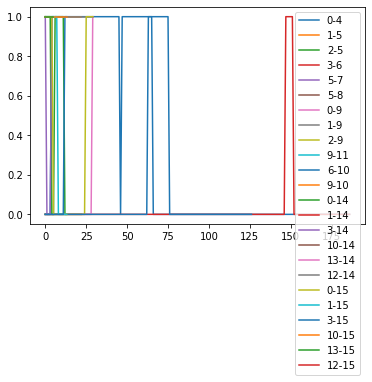

1


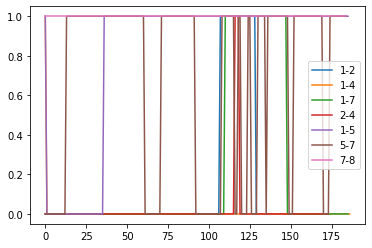

2


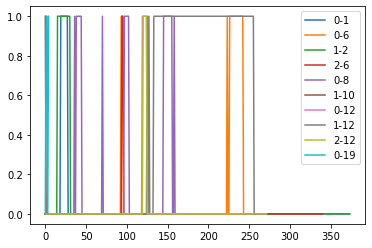

3


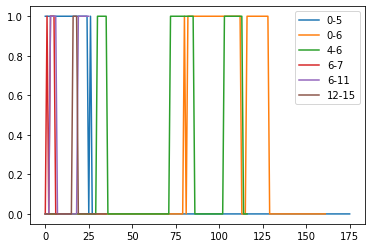

4


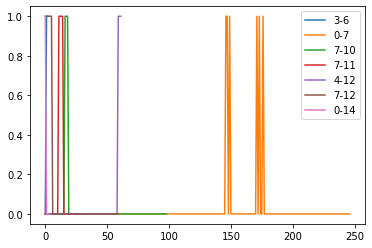

5


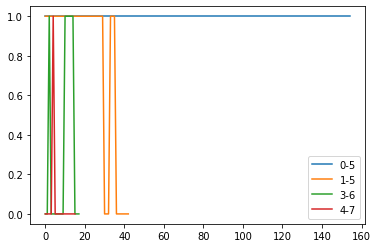

6


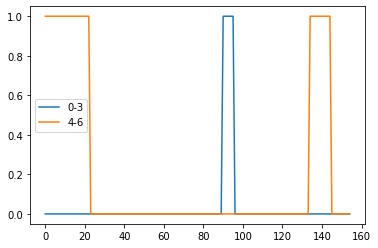

7


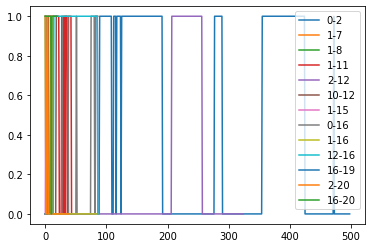

8


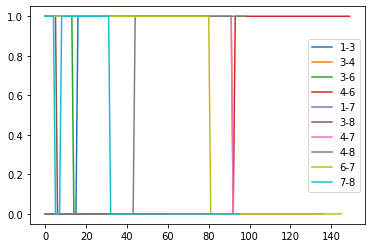

9


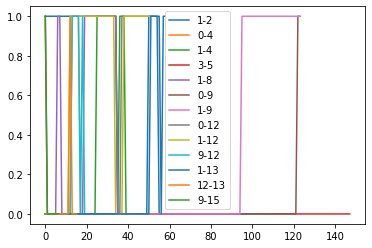

10


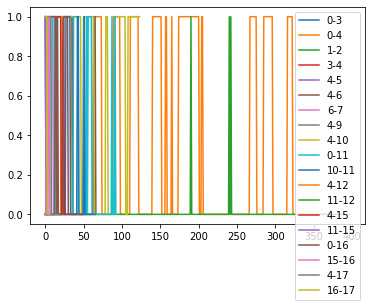

11


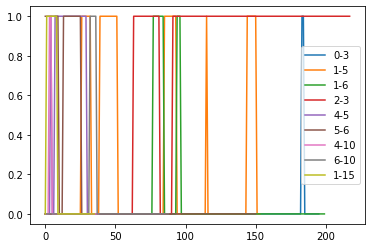

12


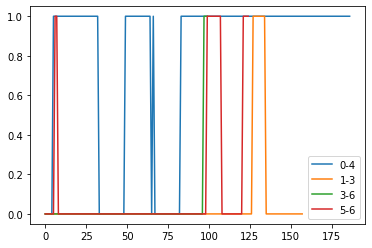

13


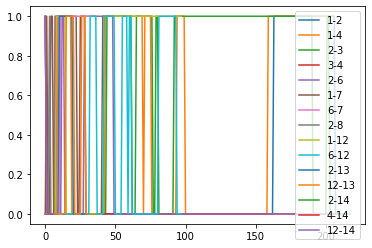

14


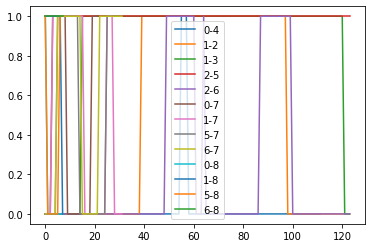

15


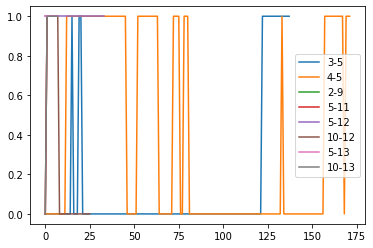

16


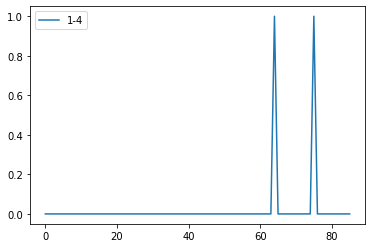

17


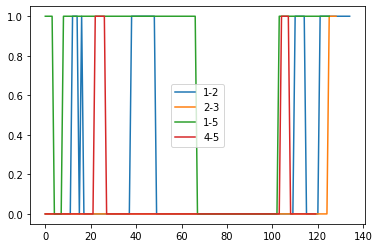

18


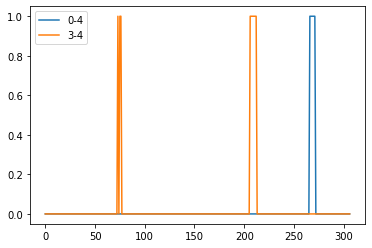

19


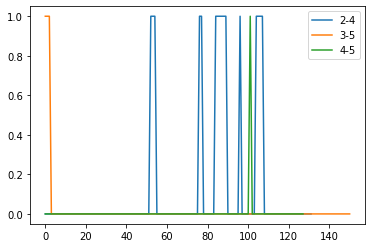

20


No handles with labels found to put in legend.


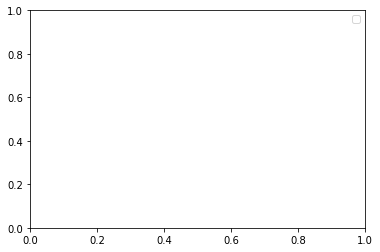

21


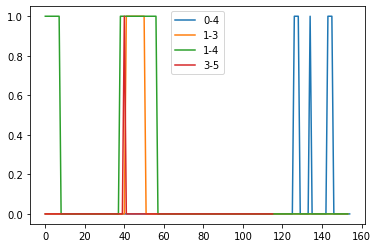

No handles with labels found to put in legend.


22


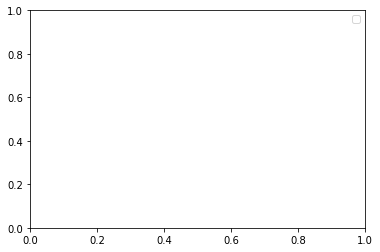

23


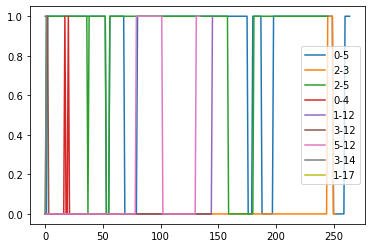

24


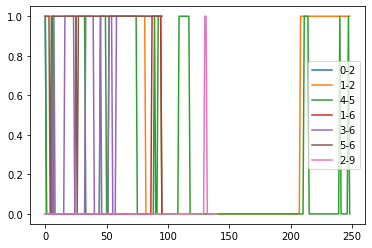

25


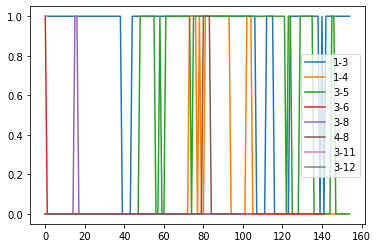

26


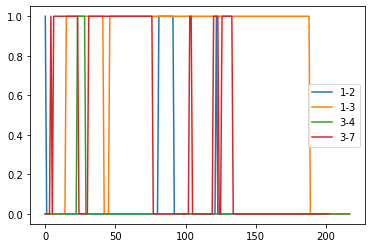

27


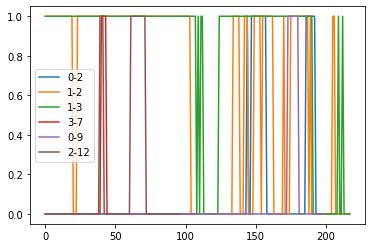

28


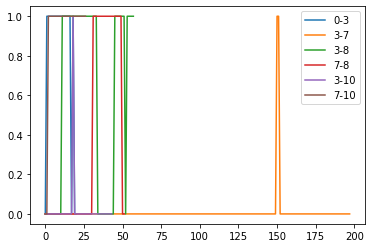

29


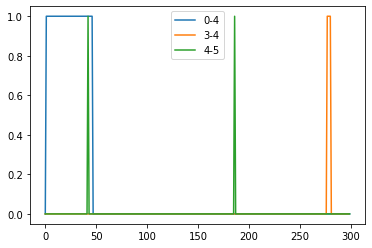

30


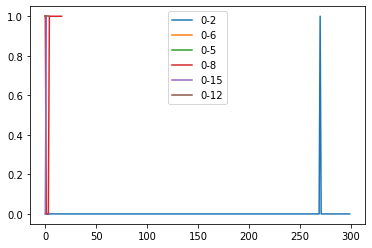

31


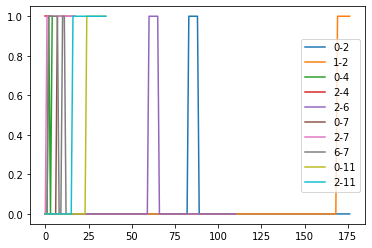

32


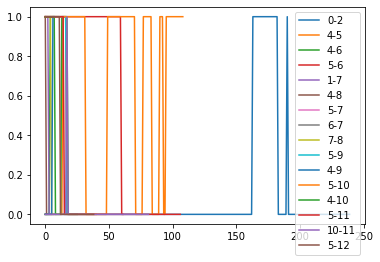

33


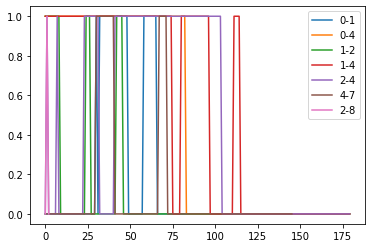

34


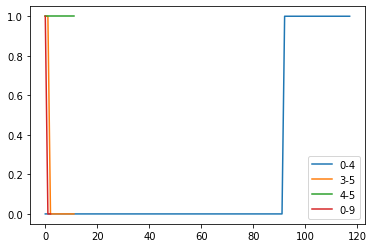

35


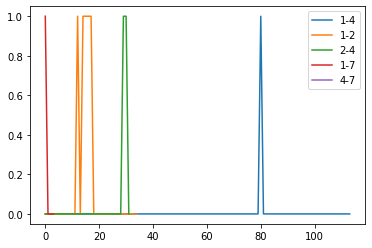

36


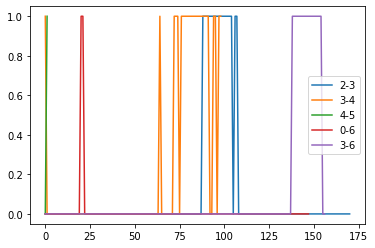

37


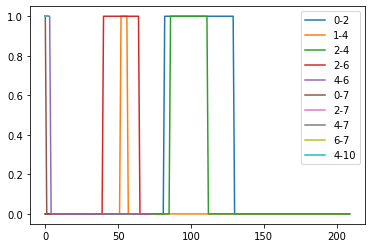

38


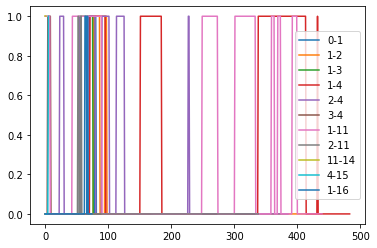

39


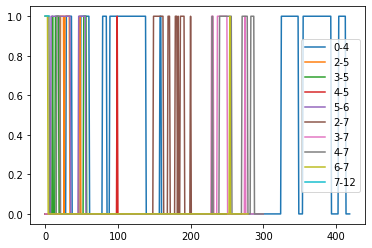

40


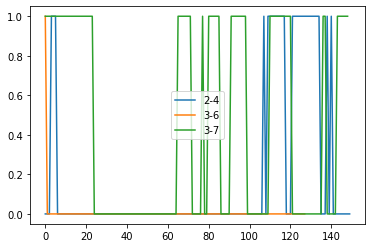

41


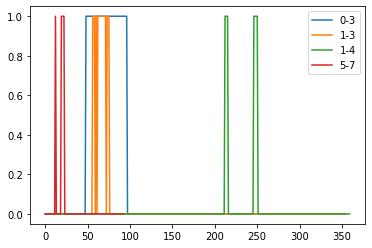

42


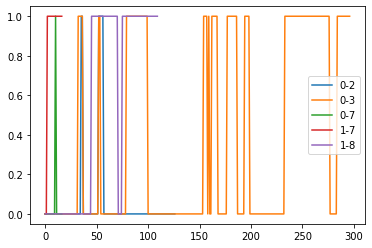

In [22]:
for i, preds_dict in enumerate(preds_lst):
    print(i)
    plot_preds(preds_dict)